## Finding target regions for gene capture

Here I will filter through the results of the exonerate alignments to pull out the regions that were hit, plus 2Kb upstream and downstream.

To do this I wrote the below function, the docstring should give all relevant details of what it does. I ran this function on the outputs of exonerate mappings of Xenopus protein sequences for each target gene to the R. temporaria assembly.

In [20]:
def exonerator_exons(gff_path, genome_path, query_name, query_length, flanking_bp, target_scaffolds = None):
    
    """

    Function to extract all alignment regions (in a non-redundant way) from
    exonerate output made using the --showtargetgff flag. The gff lines are used
    to find the hits modelled as exons on each scaffold and to extract those regions, 
    plus 2kb up and downstream of them. Where there are partially overlapping hits, the 
    extremes of the two alignemnts are taken, meaning that any region with at least 
    one hit is extracted, but regions with more than one hit are extracted only once. 
    
    USAGE:
    
    exonerator(<gff_path> , <genome_path> , <flanking_bp>)
    
    gff_path:      path (str) to exonerate gff output
    genome_path:   path (str) to the genome assembly fasta (gzipped or not)
    query_name:    Name (str) of query sequence
    query_length:  length (int) in bp of the query sequence
    flanking_bp:   length (int) of up and downstream flanking seq to output.
    target_scaffolds: optional input of a python list, containing the scaffolds to consider for that query (excluding all other scaffolds)
    
    OUTPUT:
    
    The function will output a dictionary of hits with scaffold names as keys
    and start and stop coordinates as a tuple of integers:
    
    {"Scaff_ID": (int(start), int(stop))}
    
    It will also write this to a tab delimited file and output a fasta containing the 
    target sequence segments which were hit.
    
    Finally it will print to screen, the plot of the coverage of the query, which can be 
    used to assess if any/which parts of the query could not been aligned. 
    
    """
    
    
    from matplotlib import pyplot as plt
    from Bio import SeqIO
    import gzip
    import numpy as np
    
    in_dump = False

    gff_lines = []
    query_ranges = []
    labels = []

    ## first get the gff lines out of the exonerate file

    gff = open(gff_path, 'r').readlines()
    
    for line in gff:

        if "START OF GFF DUMP" in line:

            in_dump = True

        if "END OF GFF DUMP" in line:

            in_dump = False

        if in_dump:

            if not line.startswith("#"):
                gff_lines.append(line.split())

        if "Target:" in line:
            labels.append(line.split()[1])

        if "Query range" in line:
            query_ranges.append((int(line.split()[2]), int(line.split()[4])))



    ## Now find and output the target regions with hits. 
    
    feature_dict = {}
    
    for line in gff_lines:
        
        proceed = True ## set to true as default
        
        target_scaff = line[0]
        feature_type = line[2]
        feature_strt = int(line[3])
        feature_stop = int(line[4])

        ## Make a dictionary of all CDS or 

        if target_scaffolds:
            proceed = False  ## if the target_scaffolds list is provided, set proceed = False as default
            
            if target_scaff in target_scaffolds:
                proceed = True  ## if target scaff in list of scaffolds to be retained, set proceed = True to continue, else pass.
        
        if proceed == True:

            if feature_type == "exon":

                if target_scaff not in feature_dict:

                    feature_dict[target_scaff] = {}
                    exon_index = 1

                feature_dict[target_scaff]["Exon_%s" % exon_index] = (feature_strt, feature_stop)
                exon_index += 1
            
    
    ## Now curate the exon aignments on each scaffold. If they overlap, join them and take the section encompassing both, if they don't overlap, leave them as they are. 
    
    curated_features = {}
    
    for scaff in feature_dict:
        
        if scaff not in curated_features:
            curated_features[scaff] = {}
            curated_exon_index = 1
        
        
        if len(feature_dict[scaff]) > 1:
            done = []
            for exon in feature_dict[scaff]:
                for other_exon in feature_dict[scaff]:
                    if exon != other_exon and not any([(exon, other_exon) in done, (other_exon, exon) in done]):
                        
                        ## NOTE*** when checking for overlaps - I'm going to use the flanking lengths, but keep the normal lenghts in the dictionary afterwards!
                        
                        if any([min(feature_dict[scaff][exon])-flanking_bp < min(feature_dict[scaff][other_exon])-flanking_bp < max(feature_dict[scaff][exon])+flanking_bp, 
                                min(feature_dict[scaff][exon])-flanking_bp < max(feature_dict[scaff][other_exon])+flanking_bp < max(feature_dict[scaff][exon])+flanking_bp]):
                            
                            new_strt = min([min(feature_dict[scaff][exon]), max(feature_dict[scaff][exon]), min(feature_dict[scaff][other_exon]), max(feature_dict[scaff][other_exon])])
                            new_stop = max([min(feature_dict[scaff][exon]), max(feature_dict[scaff][exon]), min(feature_dict[scaff][other_exon]), max(feature_dict[scaff][other_exon])])
                            
                            print "overlapping (scaff %s): %s , %s, STRT_1: %s, STOP_1: %s, STRT_2: %s, STOP_2: %s" % (scaff,exon,other_exon,min(feature_dict[scaff][exon])-flanking_bp, max(feature_dict[scaff][exon])+flanking_bp, min(feature_dict[scaff][other_exon])-flanking_bp, max(feature_dict[scaff][other_exon])+flanking_bp )
                            
                            curated_features[scaff]["Exon_%s" %curated_exon_index] = (new_strt, new_stop)
                            
                        else:
                            curated_features[scaff]["Exon_%s" %curated_exon_index] = (min(feature_dict[scaff][exon]), max(feature_dict[scaff][exon]))
                            
                        done.append((exon, other_exon))
                        
                curated_exon_index += 1
        else:
            curated_features[scaff] = feature_dict[scaff]
                            
                            
                        
    
    ## Plot the query coverage (note this is plotting the whole alignment length, not just the exons)

    plt.figure(figsize = (25,3+(2*np.round(len(labels)/10))))
    ax = plt.subplot(1,1,1)

    j = 1
    label = 0
    for i in query_ranges:
        
        if target_scaffolds:
            
            if labels[label] in target_scaffolds:
                plt.plot(i[0:2], [j]*2, linewidth = 4,  label = labels[label])
            
            else:
                plt.plot(i[0:2], [j]*2, linewidth = 4,  label = labels[label], color = "lightgrey")
                
        else:

            plt.plot(i[0:2], [j]*2, linewidth = 4,  label = labels[label])
        
        
        j += 1
        label += 1

    
    ## tidy up axes
    plt.xlabel("bp")
    ax.axes.get_yaxis().set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.patch.set_visible(False)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol = np.round(len(labels)/5))

    plt.title("Amount of query (%s) covered" % query_name)
    plt.ylim(0,len(labels)+3)
    plt.xlim(0, query_length)
    plt.show()
    
    
    ## Now extract the sequences plus their flanking sequence. 
    
    if not isinstance(flanking_bp, int):
        flanking_bp = int(flanking_bp)
    
    out_summary_path = "%s_OUT_summary.txt" % gff_path.rpartition(".")[0]
    out_summary = open(out_summary_path, 'w')
    
    out_summary.write("SCAFFOLD\tSTART\tSTOP\tLENGTH\n")
    
    print "==================== Hits ======================\n"
    print ('{:<30s}{:<10s}{:<10s}{:<10s}{:<10s}'.format("SCAFFOLD", "EXON", "START", "STOP", "LENGTH"))
        
    
    Sequence_total = 0
    Sequence_plus_flanking_total = 0
    
    for scaffold in curated_features:
        for exon in curated_features[scaffold]:
            exon_start = min(curated_features[scaffold][exon])
            exon_stop = max(curated_features[scaffold][exon])
            exon_length = exon_stop - exon_start

            out_summary.write("%s_%s\t%s\t%s\t%s\n" % (scaffold, exon, exon_start, exon_stop, exon_length))
            out_summary.write("%s_%s\t%s\t%s\t%s\t(with flanking regions)\n" % (scaffold, exon, exon_start-flanking_bp, exon_stop+flanking_bp, (exon_stop+flanking_bp) - (exon_start-flanking_bp)))
            
            flanking_start = (exon_start-flanking_bp)
            flanking_stop = (exon_stop+flanking_bp)
            
            if flanking_start < 0:
                flanking_start = 0
            
            
            print('{:<30s}{:<10s}{:<10d}{:<10d}{:<10d}'.format(scaffold, exon, exon_start, exon_stop, exon_length))
            print('{:<30s}{:<10s}{:<10d}{:<10d}{:<10d}{:<20s}'.format(scaffold, exon, flanking_start, flanking_stop, flanking_stop - flanking_start, "(with flanking seq)"))
            
           
            
    
    print "\nSummary written to %s" % out_summary_path
    
    ### Now retrieve the sequence segments for regions that have been hit, and output to a fasta file.     
    
    print "\nGetting segments from genome . . . "
    
    out_fasta_path = "%s_OUT_segments.fa" % gff_path.rpartition(".")[0]
    out_fasta = open(out_fasta_path, 'w')
    
    if genome_path.endswith("gz"):
        genome = SeqIO.parse(gzip.open(genome_path, 'r'), "fasta")
    else:
        genome = SeqIO.parse(open(genome_path, 'r'), "fasta")
    
    
    Sequence_total = 0
    Sequence_plus_flanking_total = 0
    
    for sequence in genome:
        
        if sequence.id in curated_features:
            for exon in curated_features[sequence.id]:

                exon_start = min(curated_features[sequence.id][exon])
                exon_stop = max(curated_features[sequence.id][exon])
                exon_length = exon_stop - exon_start

                flanking_start = (exon_start-flanking_bp)
                flanking_stop = (exon_stop+flanking_bp)
                flanking_length = flanking_stop - flanking_start
                
                if flanking_start < 0:
                    flanking_start = 0
                    
                if flanking_stop > len(sequence.seq):
                    flanking_stop = len(sequence.seq)
 
                
                Sequence_total += exon_length
                Sequence_plus_flanking_total += flanking_length
                
                seq_segment = sequence.seq[flanking_start:flanking_stop]
                out_fasta.write(">%s_%s_%s_%s_%s\n%s\n" % (query_name, sequence.id, flanking_start, flanking_stop, flanking_length, seq_segment))         

    out_fasta.close()
        
        
    print "\nSequence length totalled %s Bp" % Sequence_total
    print "\nSequence length with flanking regions (%s) totalled %s Bp" % (flanking_bp, Sequence_plus_flanking_total)
        
    print "\nDONE! Sequence segments are here %s" % out_fasta_path
    
            
        
    return(feature_dict, curated_features, Sequence_plus_flanking_total)
    

## How big a flanking region to use? 

I want to capture UTRs, but I have no idea how big to expect these to be. So I downloaded the gene models from X. tropicalis v9.0 from xenbase. From these I simply plotted the lengths of all of the UTRs in the 

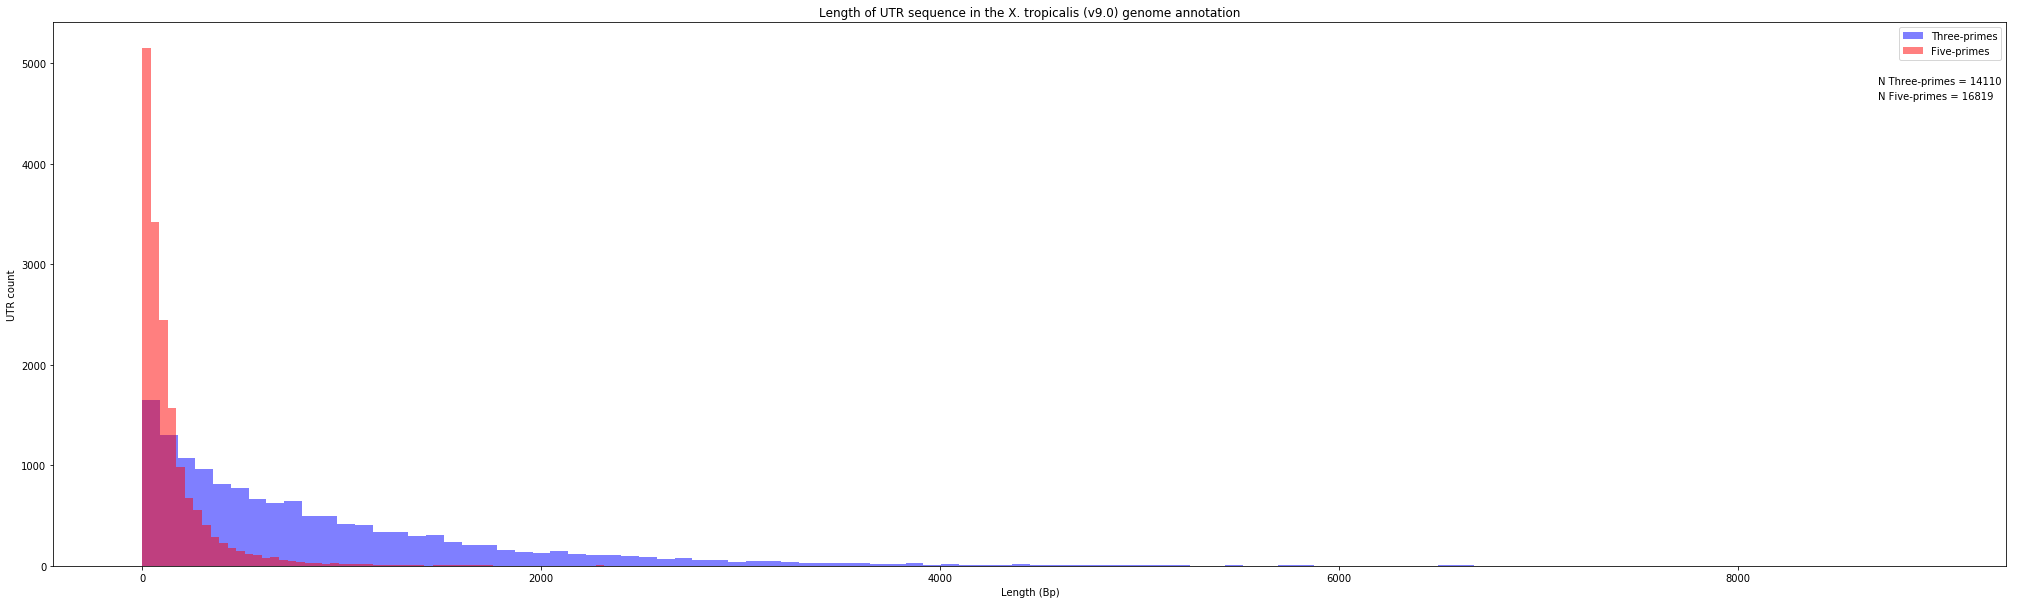

In [326]:
xen_gff = open("/home/djeffrie/Data/Sexome/Xen_genes_protein/Xtropicalisv9.0.Named.primaryTrs.gff3", 'r').readlines()

three_prime_lengths = []
five_prime_lengths = []

Three_prime_count = 0
Five_prime_count = 0

for feature in xen_gff:
    if "#" not in feature:
        if feature.split()[2] == "three_prime_UTR":
            strt = feature.split()[3]
            stop = feature.split()[4]
            three_prime_lengths.append(int(feature.split()[4]) - int(feature.split()[3]))
            Three_prime_count += 1

        elif feature.split()[2] == "five_prime_UTR":
            strt = feature.split()[3]
            stop = feature.split()[4]
            five_prime_lengths.append(int(feature.split()[4]) - int(feature.split()[3]))
            Five_prime_count += 1
        
plt.figure(figsize = (35,10))

plt.hist(three_prime_lengths, bins = 100, color = (0,0,1,0.5), label = "Three-primes")
plt.hist(five_prime_lengths, bins = 100, color = (1,0,0,0.5), label = "Five-primes")
plt.text(8700,4800,"N Three-primes = %s" % Three_prime_count)
plt.text(8700,4650,"N Five-primes = %s" % Five_prime_count)

plt.title("Length of UTR sequence in the X. tropicalis (v9.0) genome annotation")
plt.xlabel("Length (Bp)")
plt.ylabel("UTR count")
plt.legend()
plt.show()



So it does seem like 2000bp would be an ideal amount. But I'm not sure if we can afford this much. We will miss some if there is really a large UTR in one or two genes.

I also found a paper comparing human and mouse UTRs which found that they were well conserved only up to about 100bp from the coding sequence. So it is likely that a lot of the sequence in these 2kb flanking regions will have inconsistent enrichment results across the species anyway. 

## Extracting target sequence around alignments

I will now apply the above function to the exonorate outputs of each of the 12 genes. 




amh


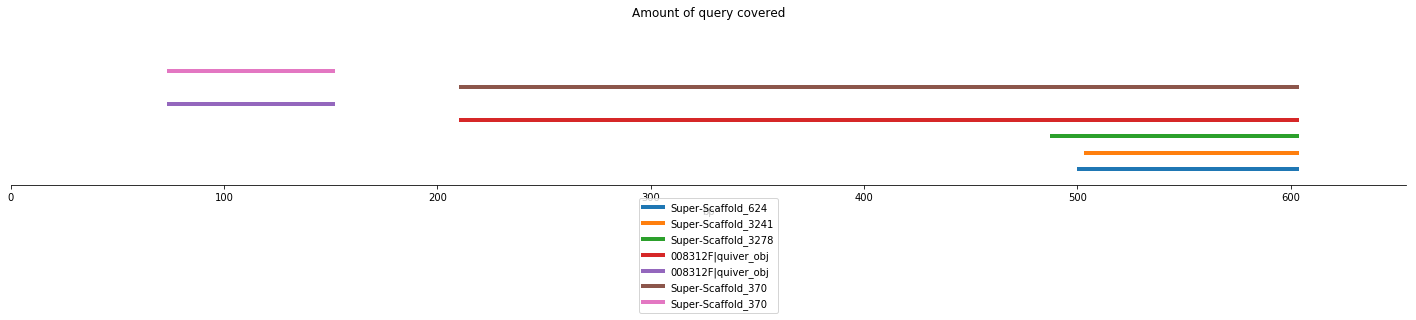

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_370            Exon_3    1094369   1094489   120       
Super-Scaffold_370            Exon_3    1093369   1095489   2120      (with flanking seq) 
Super-Scaffold_370            Exon_2    1091491   1091653   162       
Super-Scaffold_370            Exon_2    1090491   1092653   2162      (with flanking seq) 
Super-Scaffold_370            Exon_1    1083689   1084580   891       
Super-Scaffold_370            Exon_1    1082689   1085580   2891      (with flanking seq) 
Super-Scaffold_370            Exon_4    1095128   1095352   224       
Super-Scaffold_370            Exon_4    1094128   1096352   2224      (with flanking seq) 
Super-Scaffold_3241           Exon_1    741072    741368    296       
Super-Scaffold_3241           Exon_1    740072    742368    2296      (with flanking seq) 
Super-Scaffold_624            Exon_1    445397    445702    305      

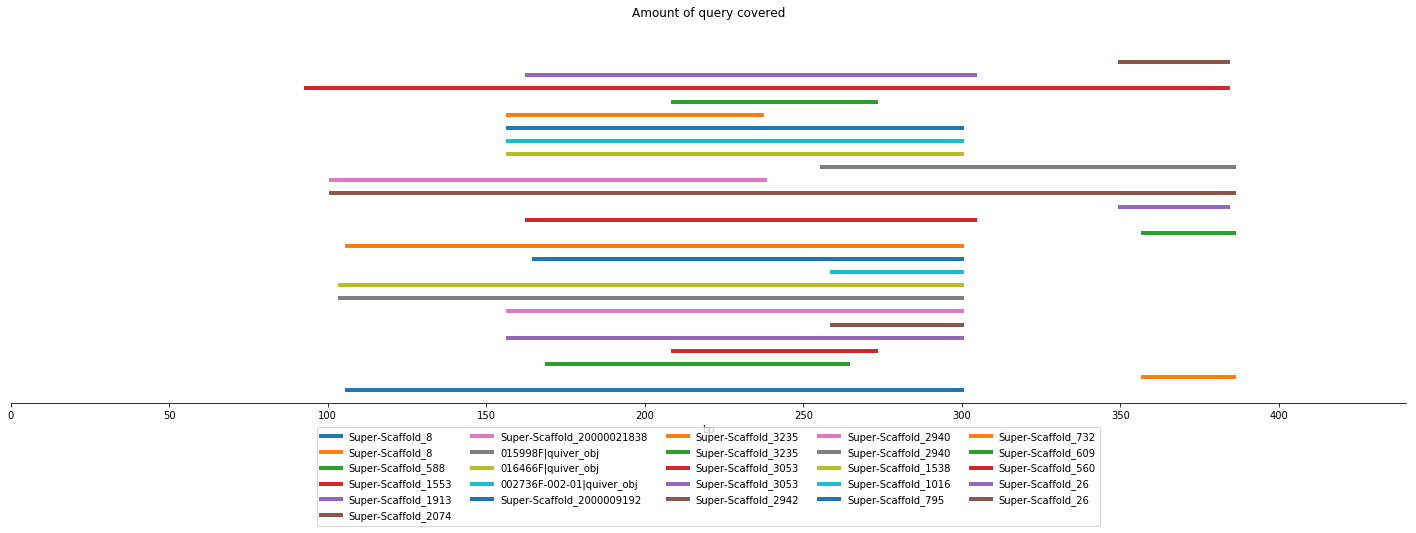

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_8              Exon_3    957134    957583    449       
Super-Scaffold_8              Exon_3    956134    958583    2449      (with flanking seq) 
Super-Scaffold_8              Exon_2    954809    954937    128       
Super-Scaffold_8              Exon_2    953809    955937    2128      (with flanking seq) 
Super-Scaffold_8              Exon_1    934858    934944    86        
Super-Scaffold_8              Exon_1    933858    935944    2086      (with flanking seq) 
Super-Scaffold_2074           Exon_1    451254    451373    119       
Super-Scaffold_2074           Exon_1    450254    452373    2119      (with flanking seq) 
Super-Scaffold_560            Exon_3    4027699   4027920   221       
Super-Scaffold_560            Exon_3    4026699   4028920   2221      (with flanking seq) 
Super-Scaffold_560            Exon_2    4023753   4023867   114      

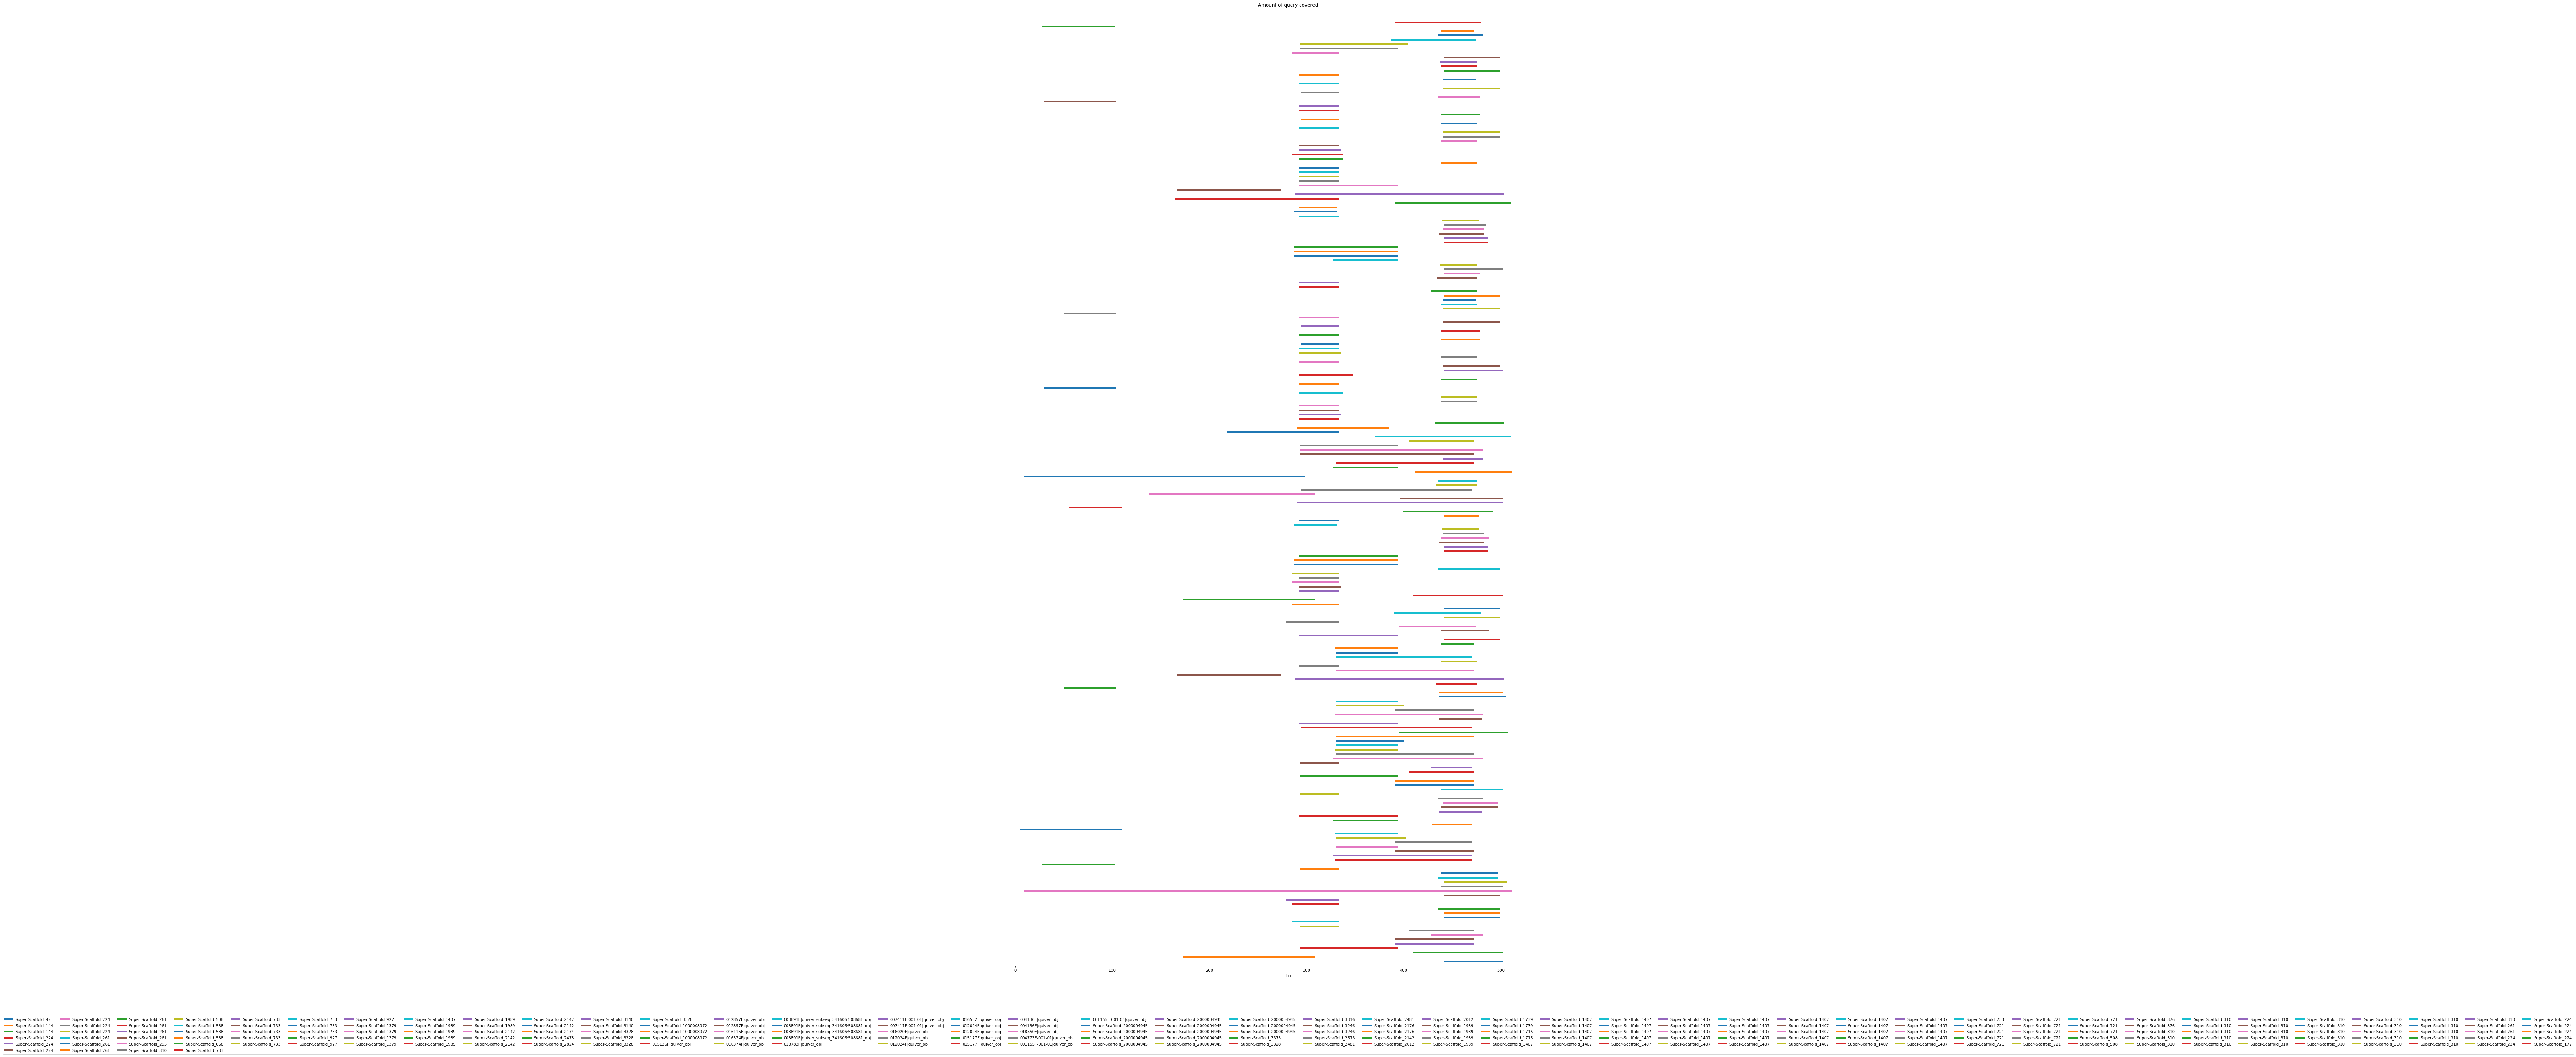

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_927            Exon_3    2257333   2257527   194       
Super-Scaffold_927            Exon_3    2256333   2258527   2194      (with flanking seq) 
Super-Scaffold_927            Exon_2    2665864   2665975   111       
Super-Scaffold_927            Exon_2    2664864   2666975   2111      (with flanking seq) 
Super-Scaffold_927            Exon_1    2661881   2662068   187       
Super-Scaffold_927            Exon_1    2660881   2663068   2187      (with flanking seq) 
Super-Scaffold_927            Exon_4    2505660   2505788   128       
Super-Scaffold_927            Exon_4    2504660   2506788   2128      (with flanking seq) 
015177F|quiver_obj            Exon_3    23741     24004     263       
015177F|quiver_obj            Exon_3    22741     25004     2263      (with flanking seq) 
015177F|quiver_obj            Exon_2    30096     30221     125      

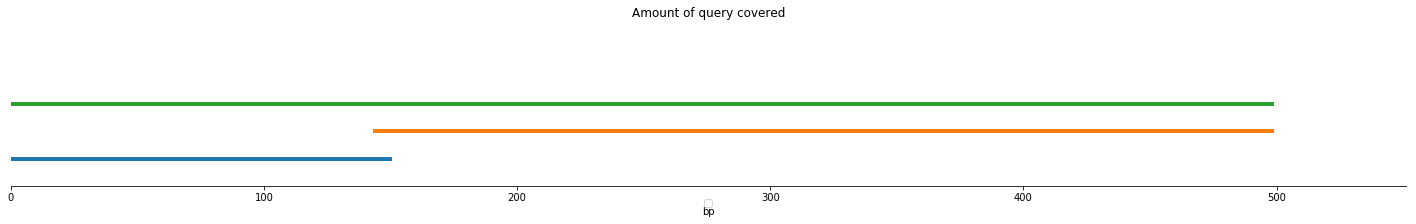

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
005034F|quiver_subseq_291091:403106_objExon_3    65470     65608     138       
005034F|quiver_subseq_291091:403106_objExon_3    64470     66608     2138      (with flanking seq) 
005034F|quiver_subseq_291091:403106_objExon_2    23656     23806     150       
005034F|quiver_subseq_291091:403106_objExon_2    22656     24806     2150      (with flanking seq) 
005034F|quiver_subseq_291091:403106_objExon_1    6553      6712      159       
005034F|quiver_subseq_291091:403106_objExon_1    5553      7712      2159      (with flanking seq) 
Super-Scaffold_640            Exon_9    650220    650396    176       
Super-Scaffold_640            Exon_9    649220    651396    2176      (with flanking seq) 
Super-Scaffold_640            Exon_8    654862    654976    114       
Super-Scaffold_640            Exon_8    653862    655976    2114      (with flanking seq) 
Super-Scaffold_

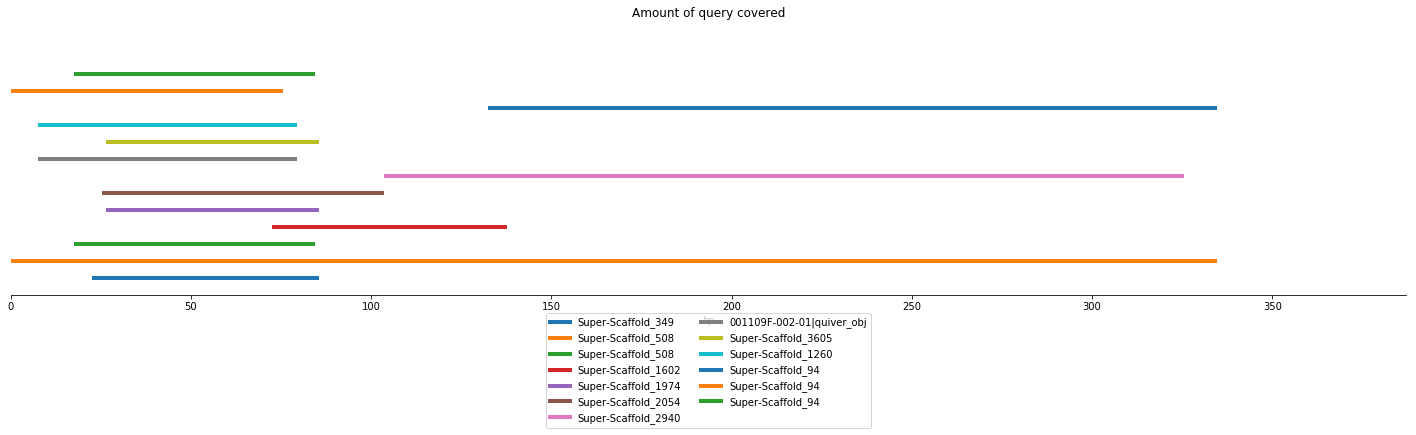

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_1260           Exon_1    140095    140307    212       
Super-Scaffold_1260           Exon_1    139095    141307    2212      (with flanking seq) 
Super-Scaffold_2054           Exon_2    2067204   2067377   173       
Super-Scaffold_2054           Exon_2    2066204   2068377   2173      (with flanking seq) 
Super-Scaffold_2054           Exon_1    2256674   2256730   56        
Super-Scaffold_2054           Exon_1    2255674   2257730   2056      (with flanking seq) 
Super-Scaffold_508            Exon_3    5445847   5446068   221       
Super-Scaffold_508            Exon_3    5444847   5447068   2221      (with flanking seq) 
Super-Scaffold_508            Exon_2    5464756   5464939   183       
Super-Scaffold_508            Exon_2    5463756   5465939   2183      (with flanking seq) 
Super-Scaffold_508            Exon_1    5495117   5495391   274      

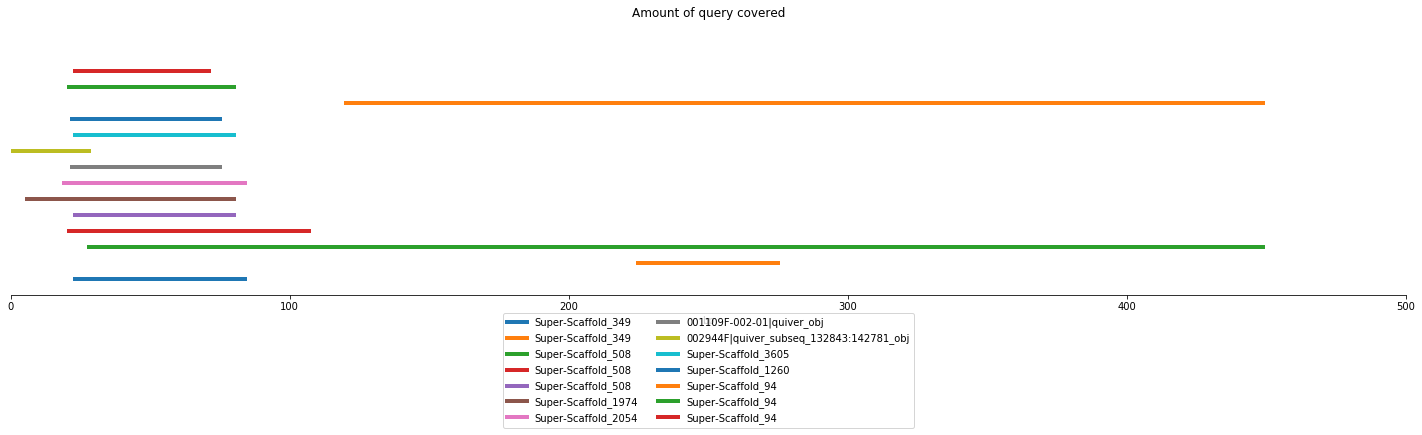

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_1260           Exon_1    140095    140253    158       
Super-Scaffold_1260           Exon_1    139095    141253    2158      (with flanking seq) 
Super-Scaffold_349            Exon_2    608895    609077    182       
Super-Scaffold_349            Exon_2    607895    610077    2182      (with flanking seq) 
Super-Scaffold_349            Exon_1    612216    612365    149       
Super-Scaffold_349            Exon_1    611216    613365    2149      (with flanking seq) 
Super-Scaffold_508            Exon_3    5634543   5634855   312       
Super-Scaffold_508            Exon_3    5633543   5635855   2312      (with flanking seq) 
Super-Scaffold_508            Exon_2    5643997   5644946   949       
Super-Scaffold_508            Exon_2    5642997   5645946   2949      (with flanking seq) 
Super-Scaffold_508            Exon_1    5791434   5791610   176      

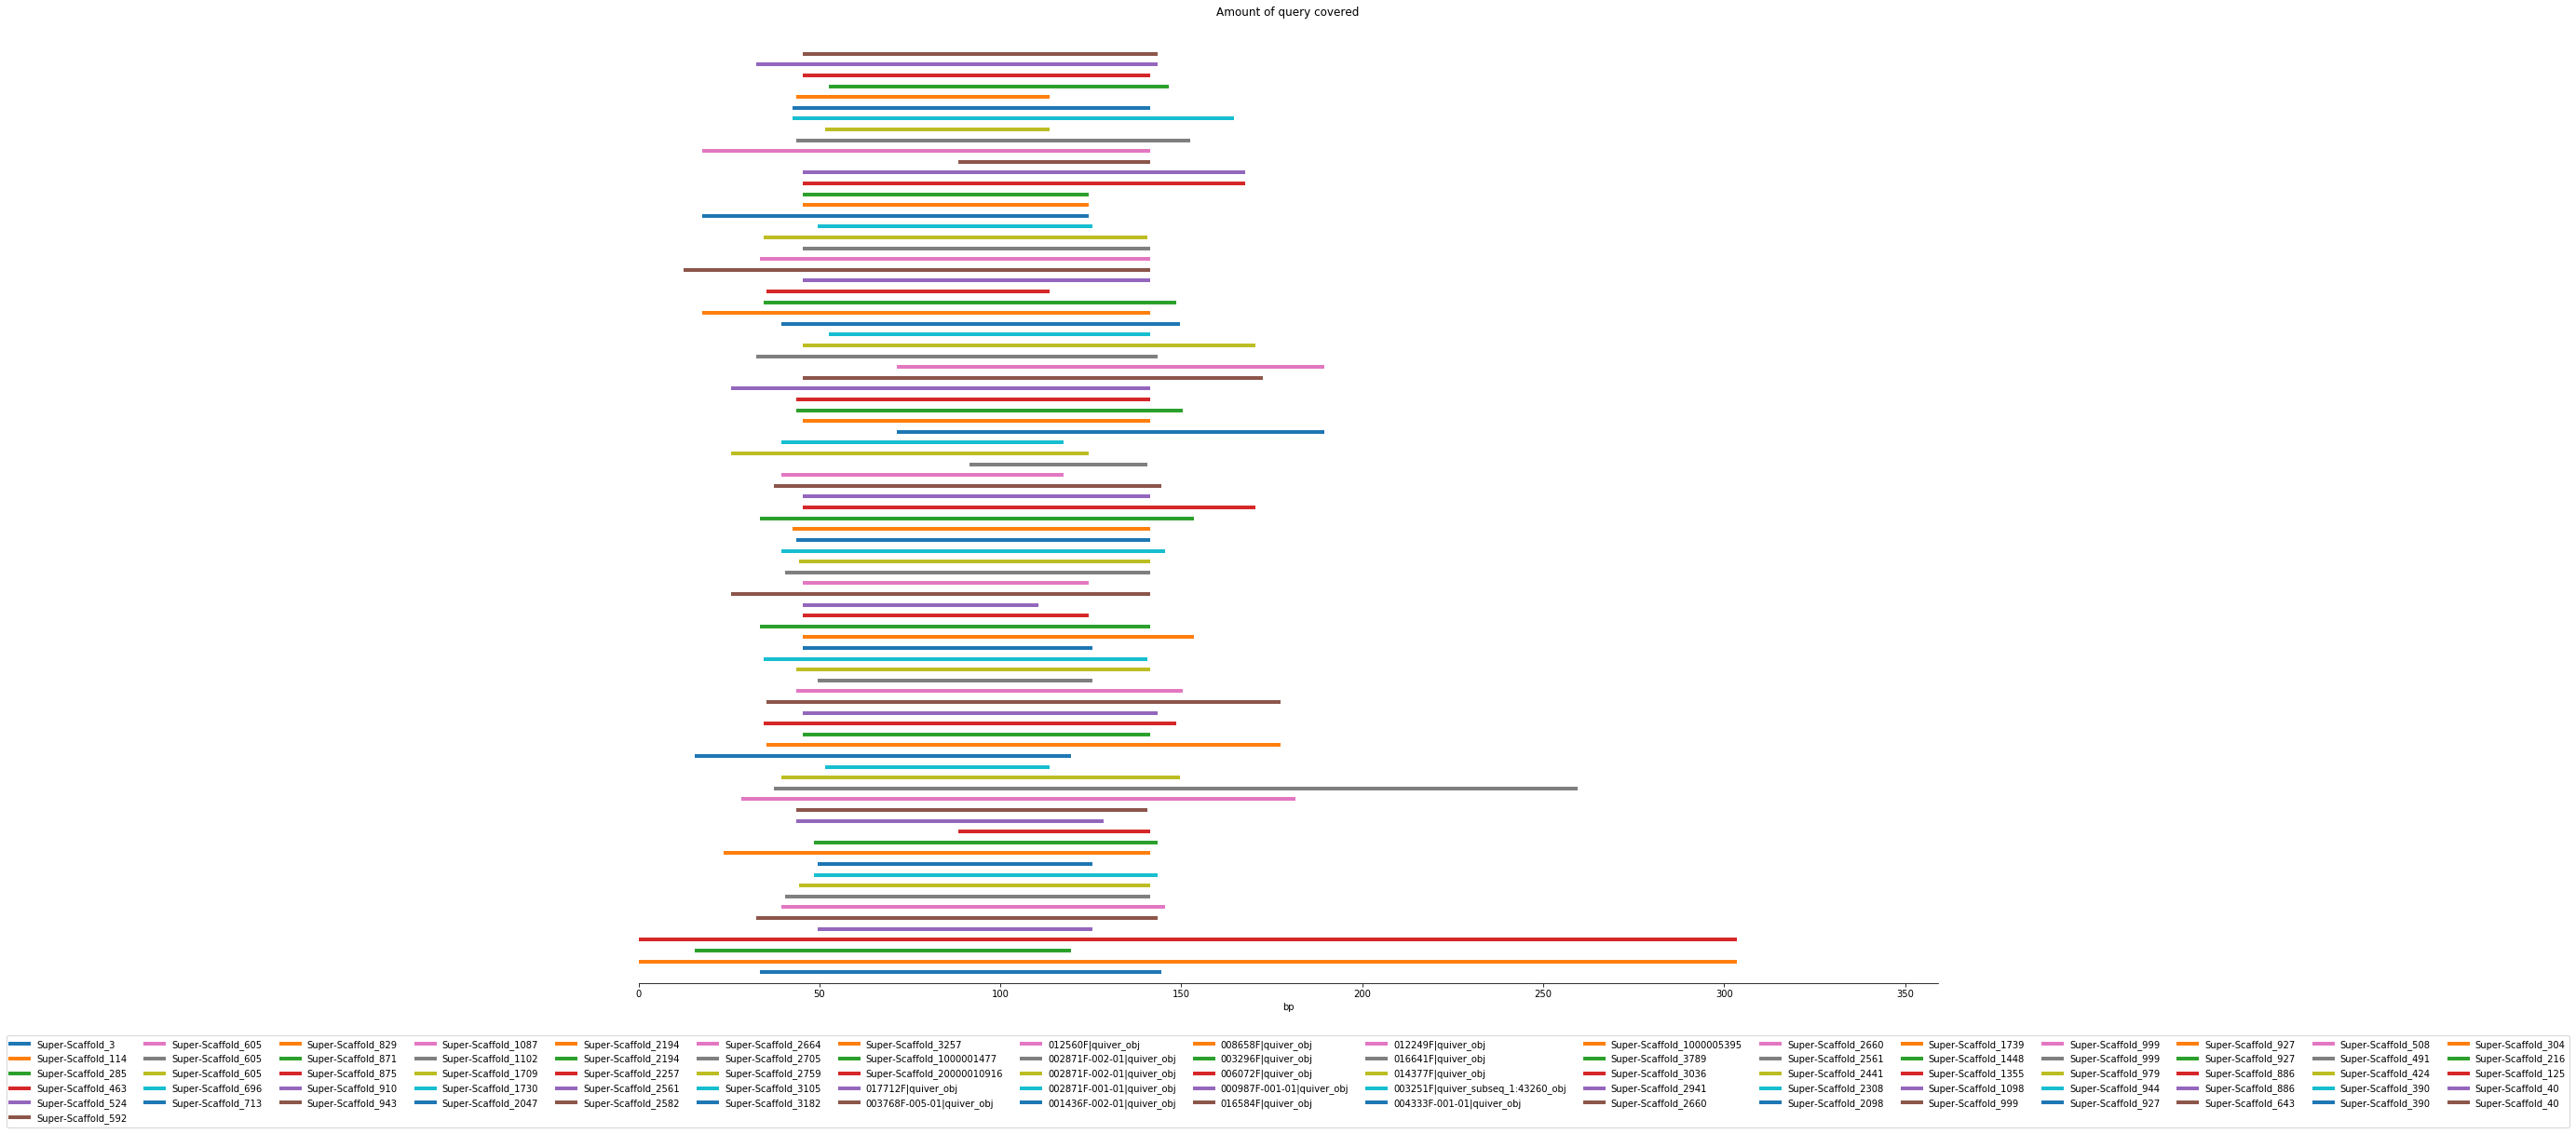

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_713            Exon_2    160982    161093    111       
Super-Scaffold_713            Exon_2    159982    162093    2111      (with flanking seq) 
Super-Scaffold_713            Exon_1    16452     16558     106       
Super-Scaffold_713            Exon_1    15452     17558     2106      (with flanking seq) 
Super-Scaffold_2047           Exon_2    162128    162355    227       
Super-Scaffold_2047           Exon_2    161128    163355    2227      (with flanking seq) 
Super-Scaffold_2047           Exon_1    188819    188899    80        
Super-Scaffold_2047           Exon_1    187819    189899    2080      (with flanking seq) 
Super-Scaffold_927            Exon_9    2712717   2712794   77        
Super-Scaffold_927            Exon_9    2711717   2713794   2077      (with flanking seq) 
Super-Scaffold_927            Exon_8    2710792   2710896   104      

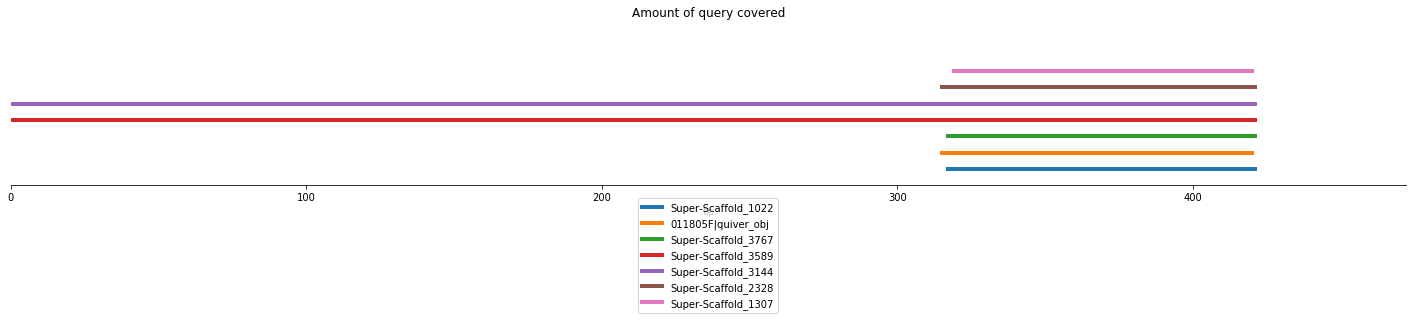

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
011805F|quiver_obj            Exon_1    6108      6425      317       
011805F|quiver_obj            Exon_1    5108      7425      2317      (with flanking seq) 
Super-Scaffold_1307           Exon_1    398768    399073    305       
Super-Scaffold_1307           Exon_1    397768    400073    2305      (with flanking seq) 
Super-Scaffold_1022           Exon_1    1657203   1657511   308       
Super-Scaffold_1022           Exon_1    1656203   1658511   2308      (with flanking seq) 
Super-Scaffold_3589           Exon_2    393964    394282    318       
Super-Scaffold_3589           Exon_2    392964    395282    2318      (with flanking seq) 
Super-Scaffold_3589           Exon_1    376851    377773    922       
Super-Scaffold_3589           Exon_1    375851    378773    2922      (with flanking seq) 
Super-Scaffold_3767           Exon_1    947248    947556    308      

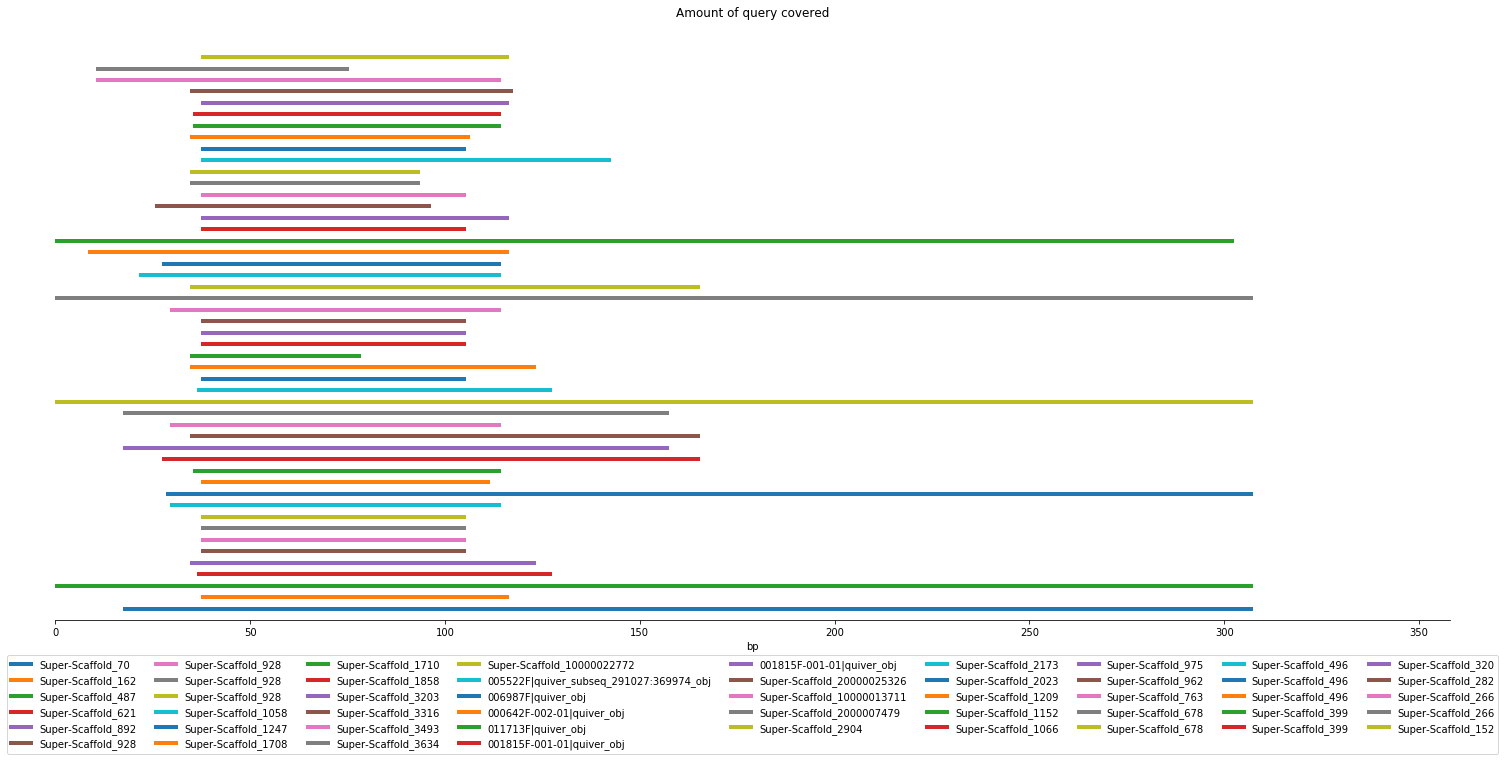

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_1247           Exon_2    3276291   3276636   345       
Super-Scaffold_1247           Exon_2    3275291   3277636   2345      (with flanking seq) 
Super-Scaffold_1247           Exon_1    3276787   3277259   472       
Super-Scaffold_1247           Exon_1    3275787   3278259   2472      (with flanking seq) 
Super-Scaffold_928            Exon_3    3163458   3163658   200       
Super-Scaffold_928            Exon_3    3162458   3164658   2200      (with flanking seq) 
Super-Scaffold_928            Exon_2    3156721   3156921   200       
Super-Scaffold_928            Exon_2    3155721   3157921   2200      (with flanking seq) 
Super-Scaffold_928            Exon_1    3150733   3150933   200       
Super-Scaffold_928            Exon_1    3149733   3151933   2200      (with flanking seq) 
Super-Scaffold_928            Exon_4    3162406   3162605   199      

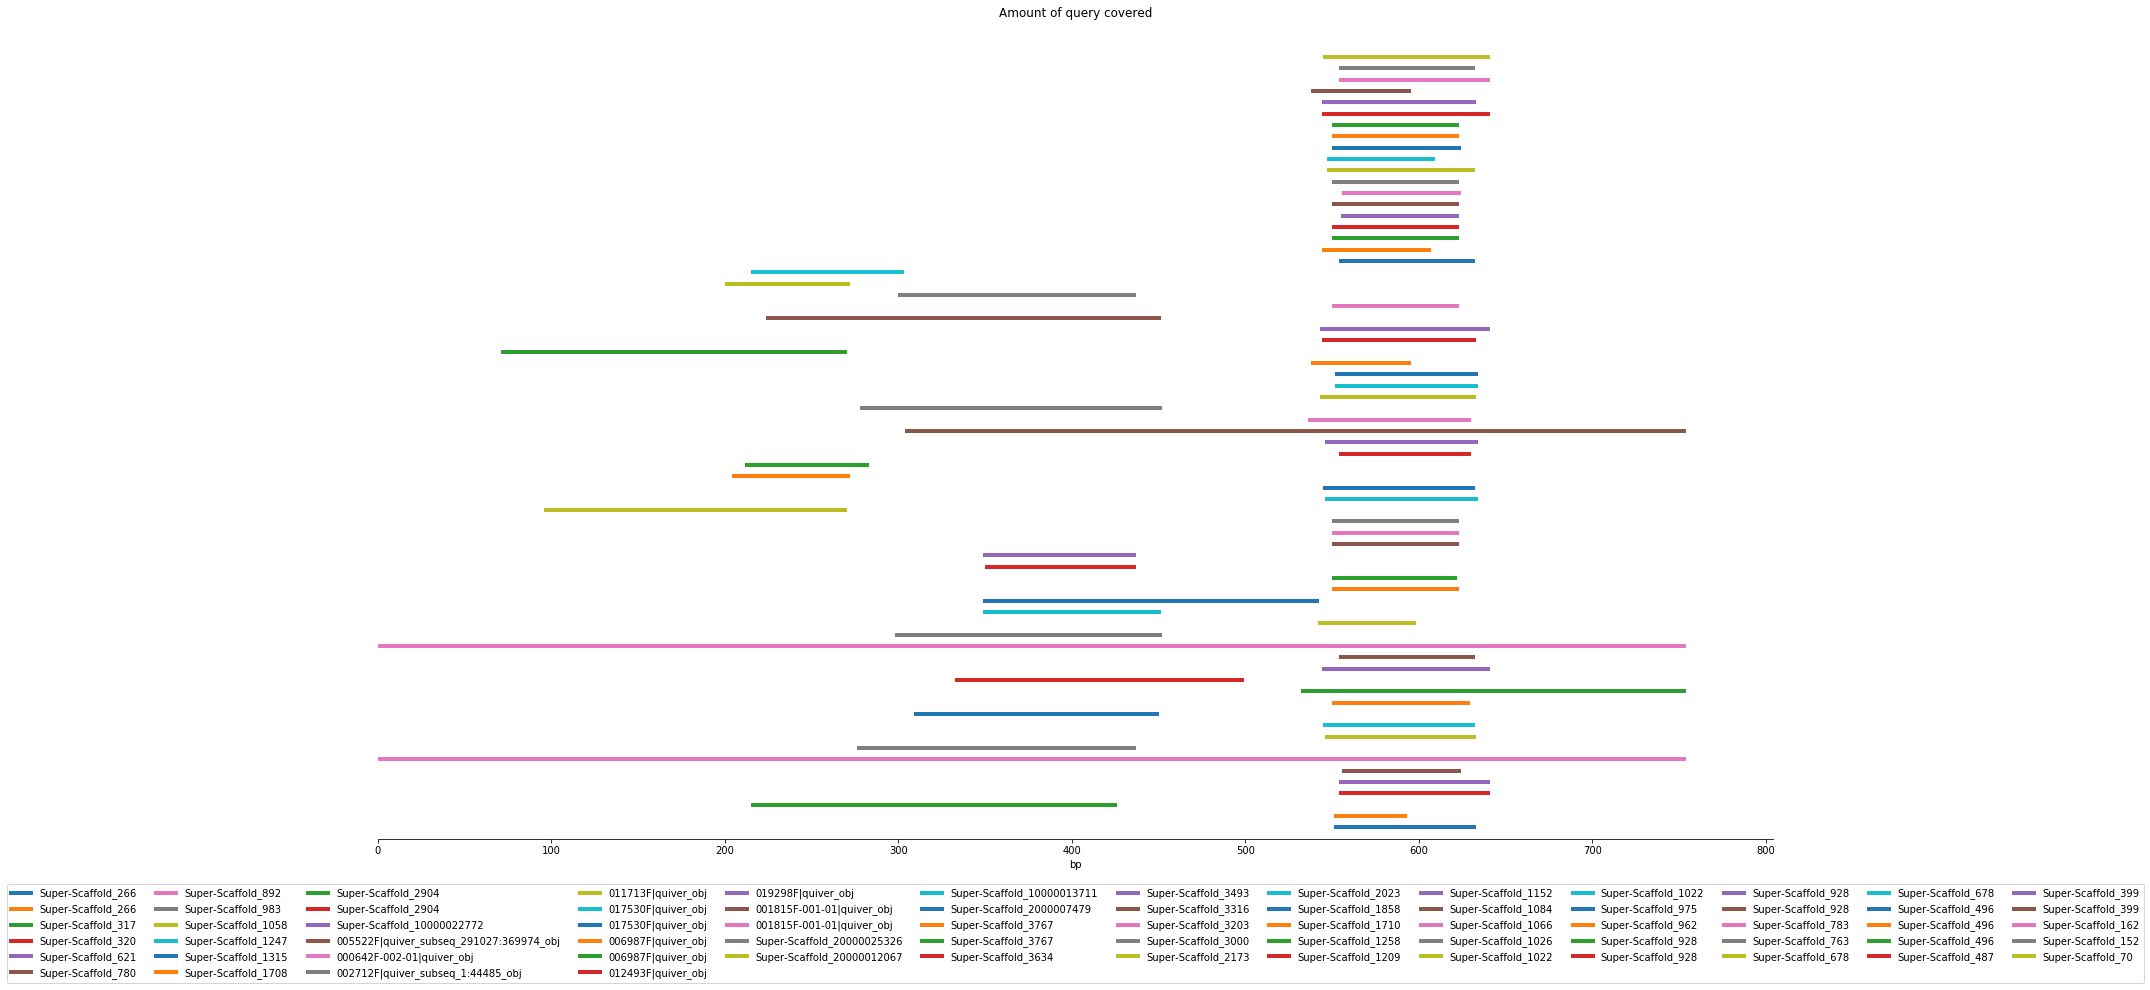

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_1315           Exon_2    1417476   1417646   170       
Super-Scaffold_1315           Exon_2    1416476   1418646   2170      (with flanking seq) 
Super-Scaffold_1315           Exon_1    1303645   1303887   242       
Super-Scaffold_1315           Exon_1    1302645   1304887   2242      (with flanking seq) 
Super-Scaffold_1247           Exon_1    3276291   3276545   254       
Super-Scaffold_1247           Exon_1    3275291   3277545   2254      (with flanking seq) 
Super-Scaffold_1026           Exon_1    202318    202722    404       
Super-Scaffold_1026           Exon_1    201318    203722    2404      (with flanking seq) 
Super-Scaffold_928            Exon_3    3156721   3156933   212       
Super-Scaffold_928            Exon_3    3155721   3157933   2212      (with flanking seq) 
Super-Scaffold_928            Exon_2    3150733   3150945   212      

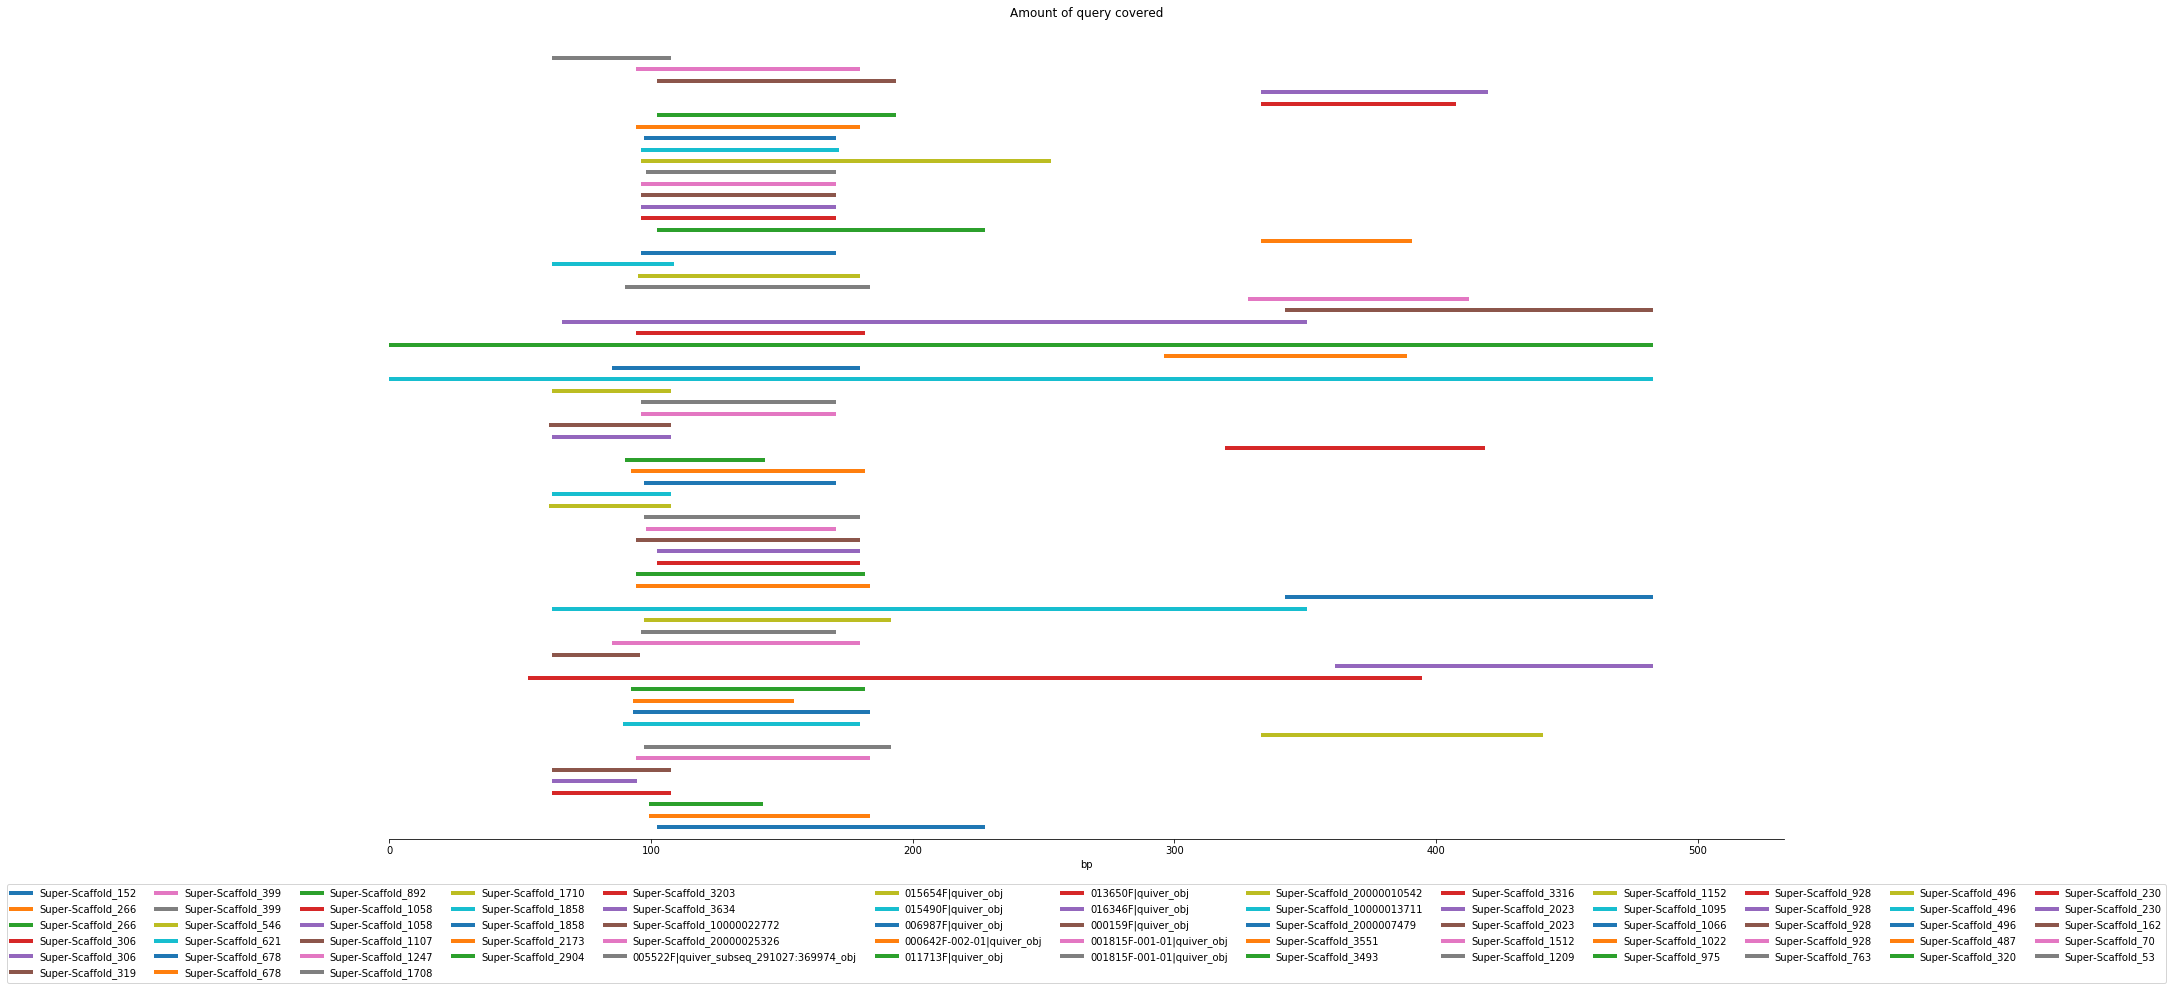

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
015490F|quiver_obj            Exon_1    38698     38829     131       
015490F|quiver_obj            Exon_1    37698     39829     2131      (with flanking seq) 
Super-Scaffold_3634           Exon_1    105123    105350    227       
Super-Scaffold_3634           Exon_1    104123    106350    2227      (with flanking seq) 
Super-Scaffold_319            Exon_1    3160987   3161118   131       
Super-Scaffold_319            Exon_1    3159987   3162118   2131      (with flanking seq) 
Super-Scaffold_1247           Exon_1    3276267   3276545   278       
Super-Scaffold_1247           Exon_1    3275267   3277545   2278      (with flanking seq) 
Super-Scaffold_928            Exon_3    3156721   3156939   218       
Super-Scaffold_928            Exon_3    3155721   3157939   2218      (with flanking seq) 
Super-Scaffold_928            Exon_2    3163458   3163676   218      

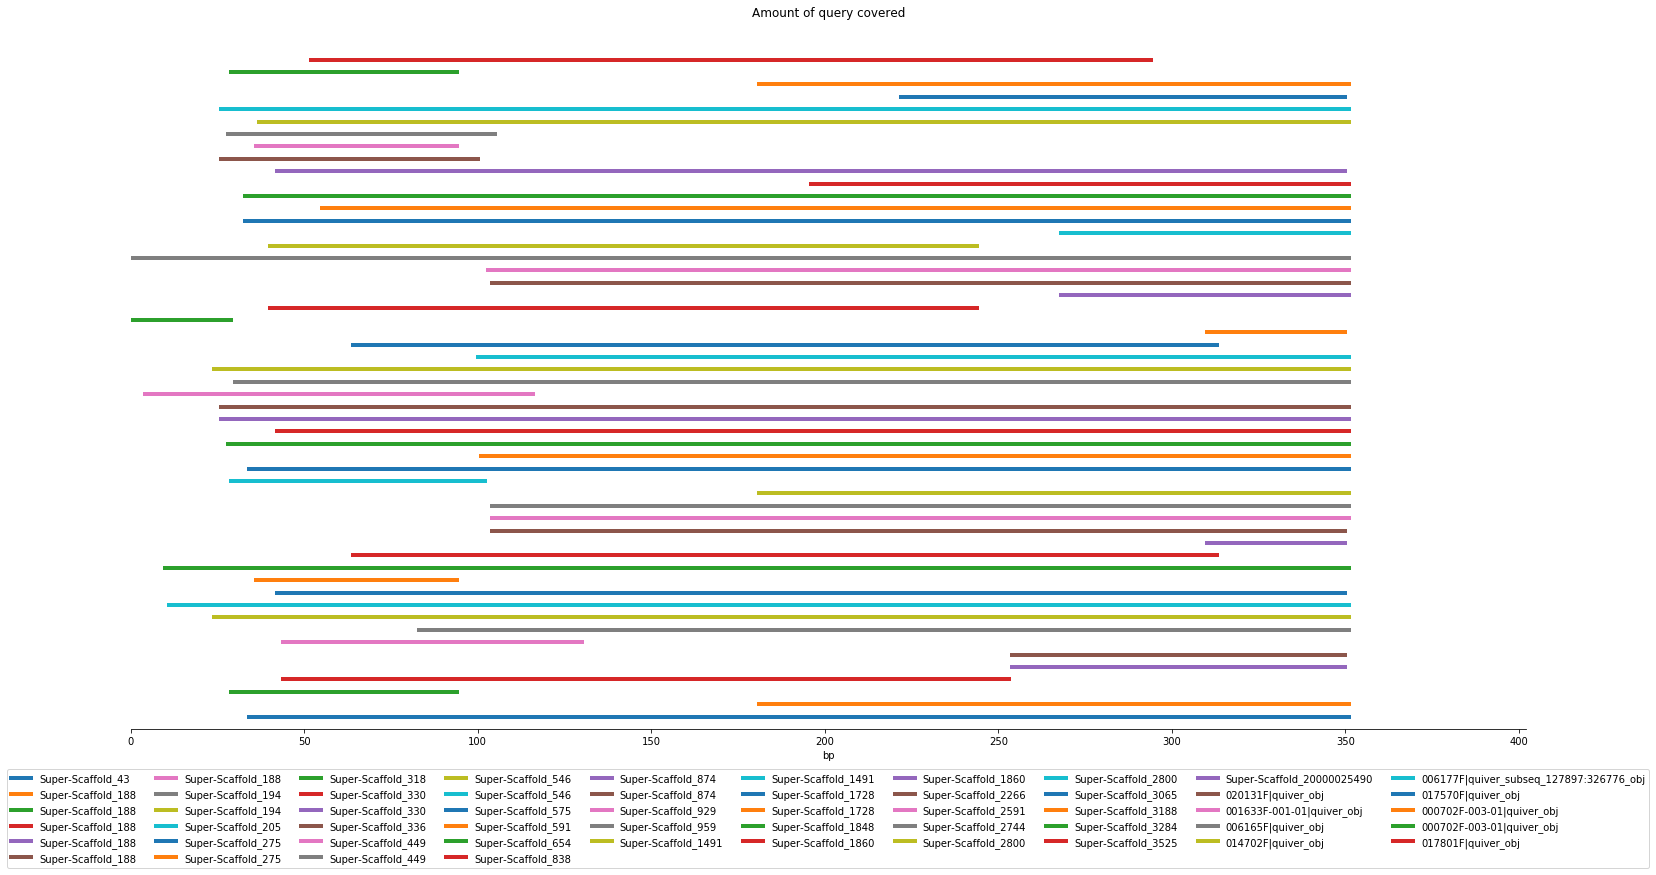

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_591            Exon_2    2151094   2151384   290       
Super-Scaffold_591            Exon_2    2150094   2152384   2290      (with flanking seq) 
Super-Scaffold_591            Exon_1    2157461   2157922   461       
Super-Scaffold_591            Exon_1    2156461   2158922   2461      (with flanking seq) 
Super-Scaffold_205            Exon_3    1801348   1801627   279       
Super-Scaffold_205            Exon_3    1800348   1802627   2279      (with flanking seq) 
Super-Scaffold_205            Exon_2    1786516   1786808   292       
Super-Scaffold_205            Exon_2    1785516   1787808   2292      (with flanking seq) 
Super-Scaffold_205            Exon_1    1768052   1768507   455       
Super-Scaffold_205            Exon_1    1767052   1769507   2455      (with flanking seq) 
Super-Scaffold_929            Exon_1    3624497   3624835   338      

In [42]:
import os


path = "/home/djeffrie/Data/Sexome/Exoneroate_protein_outs"

query_lengths = open("/home/djeffrie/Data/Sexome/Xen_genes_protein/query_lengths_AA.fasta", 'r').readlines()

hit_dict_dict = {}
curated_hit_dict = {}

Sequence_total = 0

for file in query_lengths:
    
    file_path = "%s/%s_exonor.gff" % (path, file.split(" ")[0].split(".")[0])
    query_name = file.split("_")[0]
    query_length = int(file.split(" ")[1])+50   ## multiply by 3 because the lengths there are protein, not base pairs
    
    print "\n\n========================================================================================================================"
    print "\n%s" % query_name

    
    my_gff_path = file_path
    my_genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
    flanking_bp = 1000
        

    hit_dict_dict[file], curated_hit_dict[file], Seq_total  = exonerator_exons(my_gff_path, my_genome_path, query_name, query_length, flanking_bp)
    
    Sequence_total += Seq_total

print "Total Sequence for all genes = ", Sequence_total
        


## Summary so far

So there are far too many exon alignments to keep all of them. It totals 2.2 Mb, so I need to reduce this a lot. 

I was hoping to avoid subjective judgement of the alignemnts, but I think its unavoidable. I think I just have to sort of eyeball it based on the results above, and the raw exonorate output files. However, exonorate also outputs a "Raw score" which seems quite reliable, so I can also use this to go on. 

I will come up with a set of scaffolds to retain for each query and supply these to the function above. I will then keep only the exons + flanking regions in those scaffolds. NOTE - For some genes it is quite obvious which scaffolds are the most likely to be the real alignment (e.g. dmrt1, dmrt3, cyp19a). For others, (e.g. wnt4) its not so easy so I will have to be a bit more inclusive with those genes, i.e. keeping more of the potential scaffolds. 


## "Eyeballing" results

Where there were several scaffolds which were hit by a large part of the query, often the "Raw score" outputted by exonorate was very useful. It was, in all cases. easy to come up with a small set of scaffolds for each gene which I am confident represent the true R. temporaria ortholog of these genes. 

Below I have made a list, for each query, of the scaffolds which will be retained. For each scaffold, I will, as originally intended, take just the exon and 2kb up and downstream.

In [2]:
## Scaffolds to retain for each query

amh = ['008312F|quiver_obj', 'Super-Scaffold_370']
amhr2 = ['Super-Scaffold_2942', 'Super-Scaffold_560']
cyp17a = ['Super-Scaffold_295', 'Super-Scaffold_2176']
cyp19a = ['005034F|quiver_subseq_291091:403106_obj', 'Super-Scaffold_1072', 'Super-Scaffold_640']
dmrt1 = ['Super-Scaffold_94', 'Super-Scaffold_508']
dmrt3 = ['Super-Scaffold_94', 'Super-Scaffold_508']
foxl2 = ['Super-Scaffold_114', 'Super-Scaffold_463']
gdf9 = ['Super-Scaffold_3589', 'Super-Scaffold_3144']
sox3 = ['Super-Scaffold_70', 'Super-Scaffold_487', 'Super-Scaffold_1247', 'Super-Scaffold_10000022772', 'Super-Scaffold_2000007479', 'Super-Scaffold_1152']
sox5 = ['Super-Scaffold_892', '000642F-002-01|quiver_obj']
sox9 = ['Super-Scaffold_10000013711', 'Super-Scaffold_1058', 'Super-Scaffold_1858', 'Super-Scaffold_3493', 'Super-Scaffold_2023']
wnt4 = ['006177F|quiver_subseq_127897:326776_obj', 'Super-Scaffold_2744']

Here I make a dictionary of the info for each gene to loop over and re-run using these target scaffold subsets. I have ammended the original function to include the possibility of specifying a list of scaffolds to exclusively consider. It will also plot these in colour (instead of grey) on the query coverage plots.


In [9]:

exonorate_OUTS_dict = {}


exonorate_OUTS_dict["amh"]={}
exonorate_OUTS_dict["amh"]["File"] = "amh_prot_exonor.gff"
exonorate_OUTS_dict["amh"]["target_scaffs"] = amh
exonorate_OUTS_dict["amh"]["Query_length"] = 604

exonorate_OUTS_dict["cyp17a1"]={}
exonorate_OUTS_dict["cyp17a1"]["File"] = "cyp17a1_prot_exonor.gff"
exonorate_OUTS_dict["cyp17a1"]["target_scaffs"] =cyp17a
exonorate_OUTS_dict["cyp17a1"]["Query_length"] = 512

exonorate_OUTS_dict["dmrt1"]={}
exonorate_OUTS_dict["dmrt1"]["File"] = "dmrt1_prot_exonor.gff" 
exonorate_OUTS_dict["dmrt1"]["target_scaffs"] = dmrt1
exonorate_OUTS_dict["dmrt1"]["Query_length"] = 337


exonorate_OUTS_dict["foxl2"]={}
exonorate_OUTS_dict["foxl2"]["File"] = "foxl2_prot_exonor.gff"
exonorate_OUTS_dict["foxl2"]["target_scaffs"] = foxl2
exonorate_OUTS_dict["foxl2"]["Query_length"] = 309

exonorate_OUTS_dict["sox3"]={}
exonorate_OUTS_dict["sox3"]["File"] = "sox3_prot_exonor.gff"
exonorate_OUTS_dict["sox3"]["target_scaffs"] = sox3
exonorate_OUTS_dict["sox3"]["Query_length"] = 308

exonorate_OUTS_dict["sox9"]={}
exonorate_OUTS_dict["sox9"]["File"] = "sox9_prot_exonor.gff"
exonorate_OUTS_dict["sox9"]["target_scaffs"] = sox9
exonorate_OUTS_dict["sox9"]["Query_length"] = 483

exonorate_OUTS_dict["amhr2"]={}
exonorate_OUTS_dict["amhr2"]["File"] = "amhr2_prot_exonor.gff" 
exonorate_OUTS_dict["amhr2"]["target_scaffs"] = amhr2
exonorate_OUTS_dict["amhr2"]["Query_length"] = 390

exonorate_OUTS_dict["cyp19a1"]={}
exonorate_OUTS_dict["cyp19a1"]["File"] = "cyp19a1_prot_exonor.gff" 
exonorate_OUTS_dict["cyp19a1"]["target_scaffs"] = cyp19a
exonorate_OUTS_dict["cyp19a1"]["Query_length"] = 501

exonorate_OUTS_dict["dmrt3"]={}
exonorate_OUTS_dict["dmrt3"]["File"] = "dmrt3_prot_exonor.gff" 
exonorate_OUTS_dict["dmrt3"]["target_scaffs"] = dmrt3
exonorate_OUTS_dict["dmrt3"]["Query_length"] = 450

exonorate_OUTS_dict["gdf9"]={}
exonorate_OUTS_dict["gdf9"]["File"] = "gdf9_prot_exonor.gff"  
exonorate_OUTS_dict["gdf9"]["target_scaffs"] = gdf9
exonorate_OUTS_dict["gdf9"]["Query_length"] = 422

exonorate_OUTS_dict["sox5"]={}
exonorate_OUTS_dict["sox5"]["File"] = "sox5_prot_exonor.gff"  
exonorate_OUTS_dict["sox5"]["target_scaffs"] = sox5
exonorate_OUTS_dict["sox5"]["Query_length"] = 754

exonorate_OUTS_dict["wnt4"]={}
exonorate_OUTS_dict["wnt4"]["File"] = "wnt4_prot_exonor.gff"
exonorate_OUTS_dict["wnt4"]["target_scaffs"] = wnt4
exonorate_OUTS_dict["wnt4"]["Query_length"] = 352


amh

overlapping (scaff Super-Scaffold_370): Exon_2 , Exon_1, STRT_1: 1089491, STOP_1: 1093653, STRT_2: 1092369, STOP_2: 1096489
overlapping (scaff Super-Scaffold_370): Exon_2 , Exon_4, STRT_1: 1089491, STOP_1: 1093653, STRT_2: 1093128, STOP_2: 1097352
overlapping (scaff Super-Scaffold_370): Exon_1 , Exon_4, STRT_1: 1092369, STOP_1: 1096489, STRT_2: 1093128, STOP_2: 1097352
overlapping (scaff 008312F|quiver_obj): Exon_2 , Exon_1, STRT_1: 167691, STOP_1: 171853, STRT_2: 164180, STOP_2: 168300
overlapping (scaff 008312F|quiver_obj): Exon_1 , Exon_4, STRT_1: 164180, STOP_1: 168300, STRT_2: 163317, STOP_2: 167541


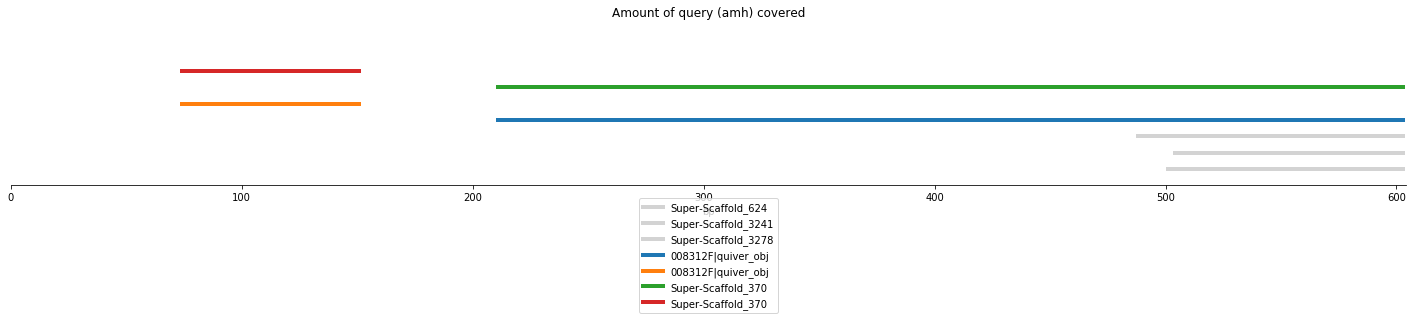

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_370            Exon_3    1094369   1095352   983       
Super-Scaffold_370            Exon_3    1092369   1097352   4983      (with flanking seq) 
Super-Scaffold_370            Exon_2    1091491   1095352   3861      
Super-Scaffold_370            Exon_2    1089491   1097352   7861      (with flanking seq) 
Super-Scaffold_370            Exon_1    1083689   1084580   891       
Super-Scaffold_370            Exon_1    1081689   1086580   4891      (with flanking seq) 
008312F|quiver_obj            Exon_3    165317    166300    983       
008312F|quiver_obj            Exon_3    163317    168300    4983      (with flanking seq) 
008312F|quiver_obj            Exon_2    169691    169853    162       
008312F|quiver_obj            Exon_2    167691    171853    4162      (with flanking seq) 
008312F|quiver_obj            Exon_1    176766    177657    891      

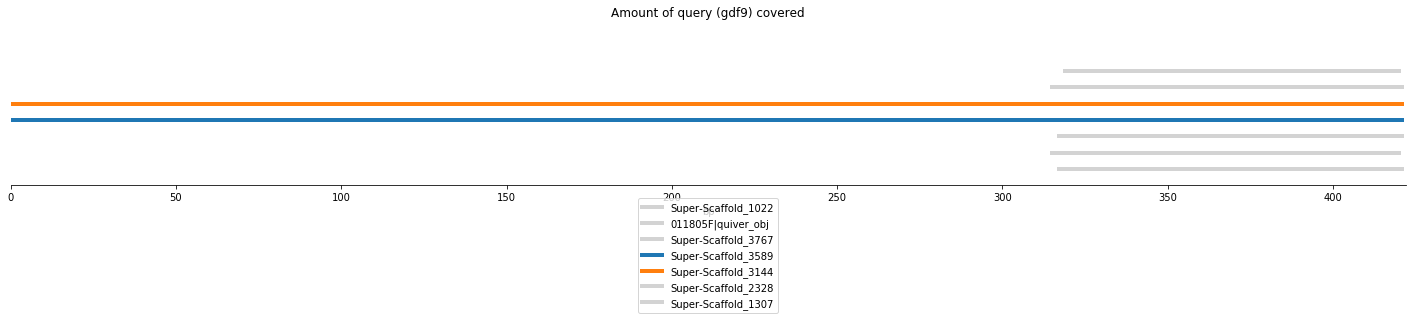

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_3589           Exon_1    376851    377773    922       
Super-Scaffold_3589           Exon_1    374851    379773    4922      (with flanking seq) 
Super-Scaffold_3144           Exon_1    26686     27608     922       
Super-Scaffold_3144           Exon_1    24686     29608     4922      (with flanking seq) 

Summary written to /home/djeffrie/Data/Sexome/Exoneroate_protein_outs//gdf9_prot_exonor_OUT_summary.txt

Getting segments from genome . . . 

Sequence length totalled 1844 Bp

Sequence length with flanking regions (2000) totalled 9844 Bp

DONE! Sequence segments are here /home/djeffrie/Data/Sexome/Exoneroate_protein_outs//gdf9_prot_exonor_OUT_segments.fa

cyp19a1

overlapping (scaff Super-Scaffold_640): Exon_6 , Exon_5, STRT_1: 653089, STOP_1: 657203, STRT_2: 652862, STOP_2: 656976
overlapping (scaff Super-Scaffold_1072): Exon_3 , Exon_2, STRT_1: 2

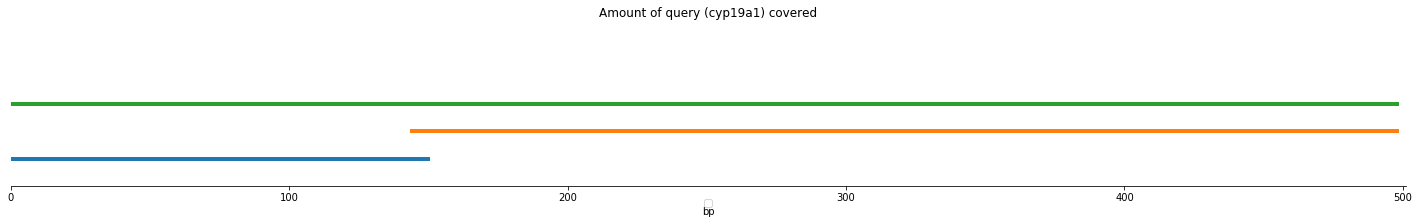

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
005034F|quiver_subseq_291091:403106_objExon_2    23656     23806     150       
005034F|quiver_subseq_291091:403106_objExon_2    21656     25806     4150      (with flanking seq) 
005034F|quiver_subseq_291091:403106_objExon_1    6553      6712      159       
005034F|quiver_subseq_291091:403106_objExon_1    4553      8712      4159      (with flanking seq) 
Super-Scaffold_640            Exon_8    654862    654976    114       
Super-Scaffold_640            Exon_8    652862    656976    4114      (with flanking seq) 
Super-Scaffold_640            Exon_3    627184    627338    154       
Super-Scaffold_640            Exon_3    625184    629338    4154      (with flanking seq) 
Super-Scaffold_640            Exon_2    667818    668059    241       
Super-Scaffold_640            Exon_2    665818    670059    4241      (with flanking seq) 
Super-Scaffold_640            Exo

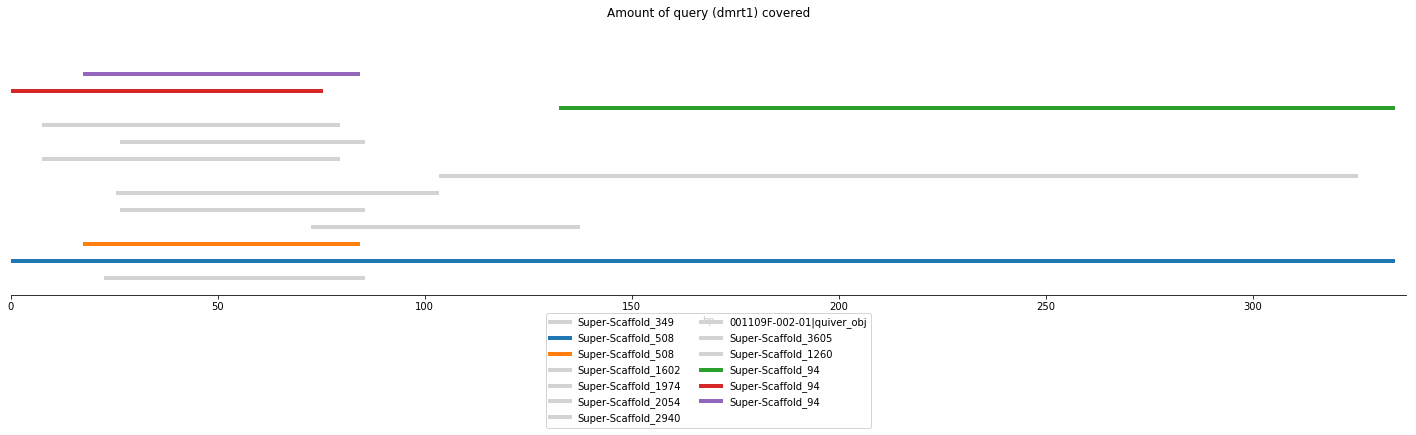

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_94             Exon_3    18290023  18290304  281       
Super-Scaffold_94             Exon_3    18288023  18292304  4281      (with flanking seq) 
Super-Scaffold_94             Exon_2    18263203  18263368  165       
Super-Scaffold_94             Exon_2    18261203  18265368  4165      (with flanking seq) 
Super-Scaffold_94             Exon_1    18201556  18201701  145       
Super-Scaffold_94             Exon_1    18199556  18203701  4145      (with flanking seq) 
Super-Scaffold_94             Exon_4    18014921  18015118  197       
Super-Scaffold_94             Exon_4    18012921  18017118  4197      (with flanking seq) 
Super-Scaffold_508            Exon_3    5445847   5446068   221       
Super-Scaffold_508            Exon_3    5443847   5448068   4221      (with flanking seq) 
Super-Scaffold_508            Exon_2    5464756   5464939   183      

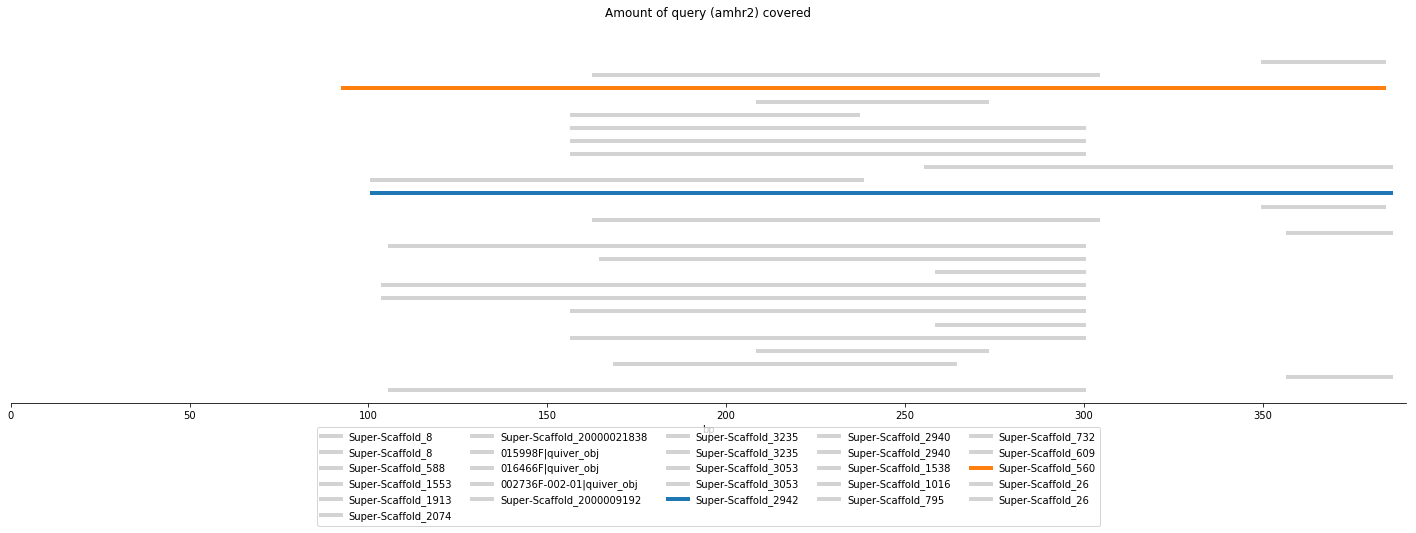

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_560            Exon_3    4027699   4027920   221       
Super-Scaffold_560            Exon_3    4025699   4029920   4221      (with flanking seq) 
Super-Scaffold_560            Exon_2    4023753   4023867   114       
Super-Scaffold_560            Exon_2    4021753   4025867   4114      (with flanking seq) 
Super-Scaffold_560            Exon_1    4000491   4000877   386       
Super-Scaffold_560            Exon_1    3998491   4002877   4386      (with flanking seq) 
Super-Scaffold_560            Exon_5    3993947   3994086   139       
Super-Scaffold_560            Exon_5    3991947   3996086   4139      (with flanking seq) 
Super-Scaffold_560            Exon_4    3990264   3990362   98        
Super-Scaffold_560            Exon_4    3988264   3992362   4098      (with flanking seq) 
Super-Scaffold_2942           Exon_1    330487    331314    827      

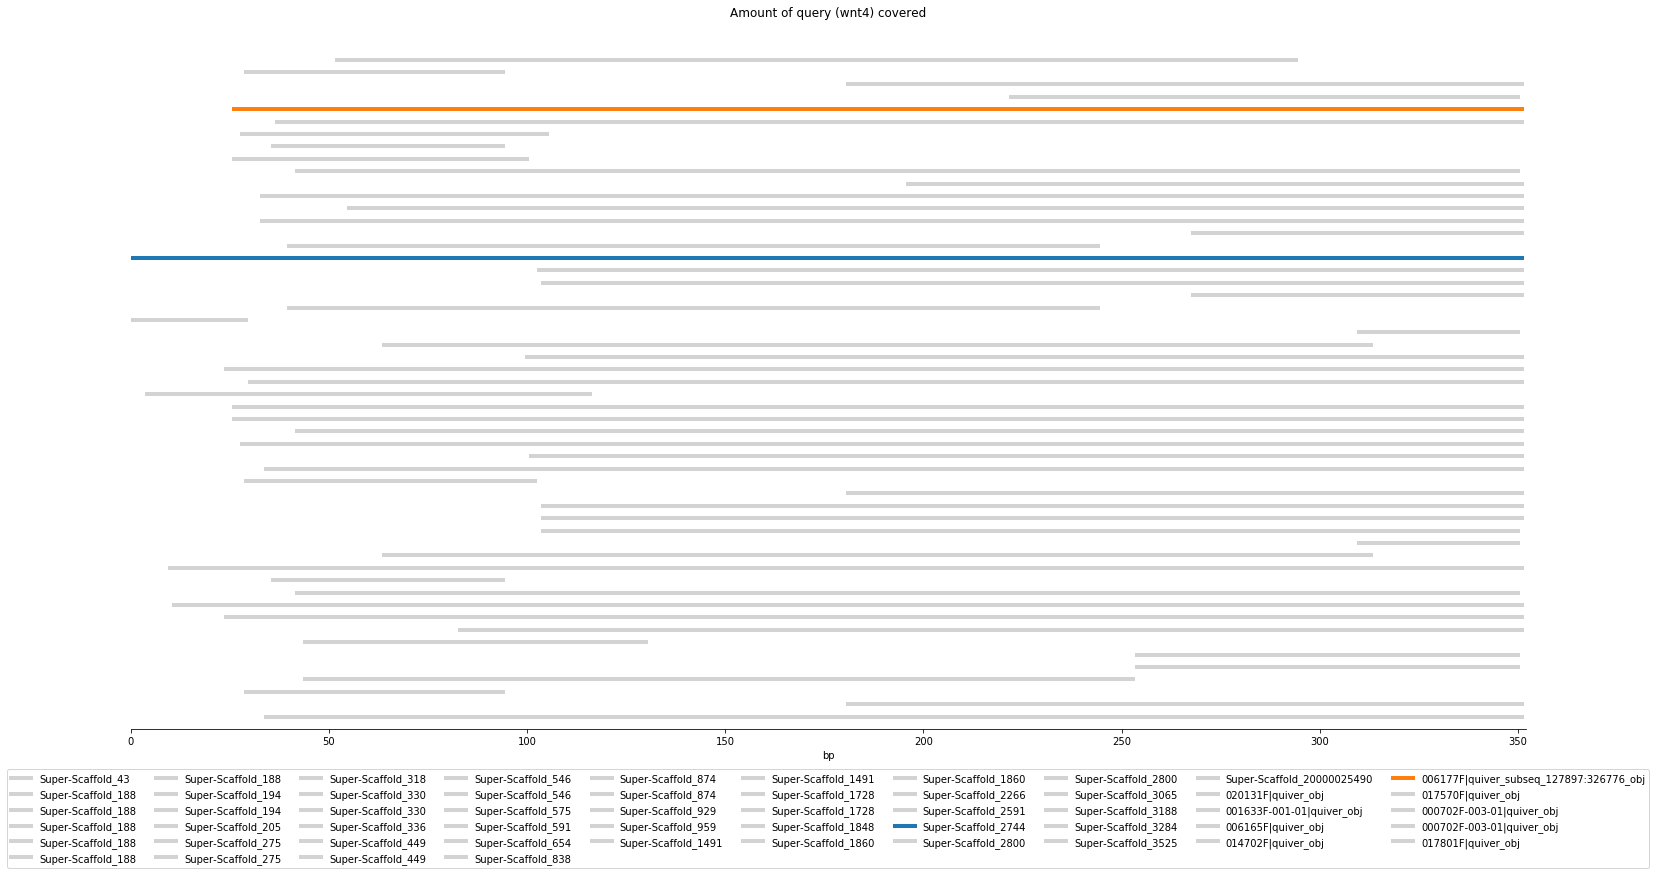

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
006177F|quiver_subseq_127897:326776_objExon_3    20199     20433     234       
006177F|quiver_subseq_127897:326776_objExon_3    18199     22433     4234      (with flanking seq) 
006177F|quiver_subseq_127897:326776_objExon_2    55164     55295     131       
006177F|quiver_subseq_127897:326776_objExon_2    53164     57295     4131      (with flanking seq) 
006177F|quiver_subseq_127897:326776_objExon_1    60149     61178     1029      
006177F|quiver_subseq_127897:326776_objExon_1    58149     63178     5029      (with flanking seq) 
Super-Scaffold_2744           Exon_3    97096     97172     76        
Super-Scaffold_2744           Exon_3    95096     99172     4076      (with flanking seq) 
Super-Scaffold_2744           Exon_2    167329    167564    235       
Super-Scaffold_2744           Exon_2    165329    169564    4235      (with flanking seq) 
Super-Scaffold_

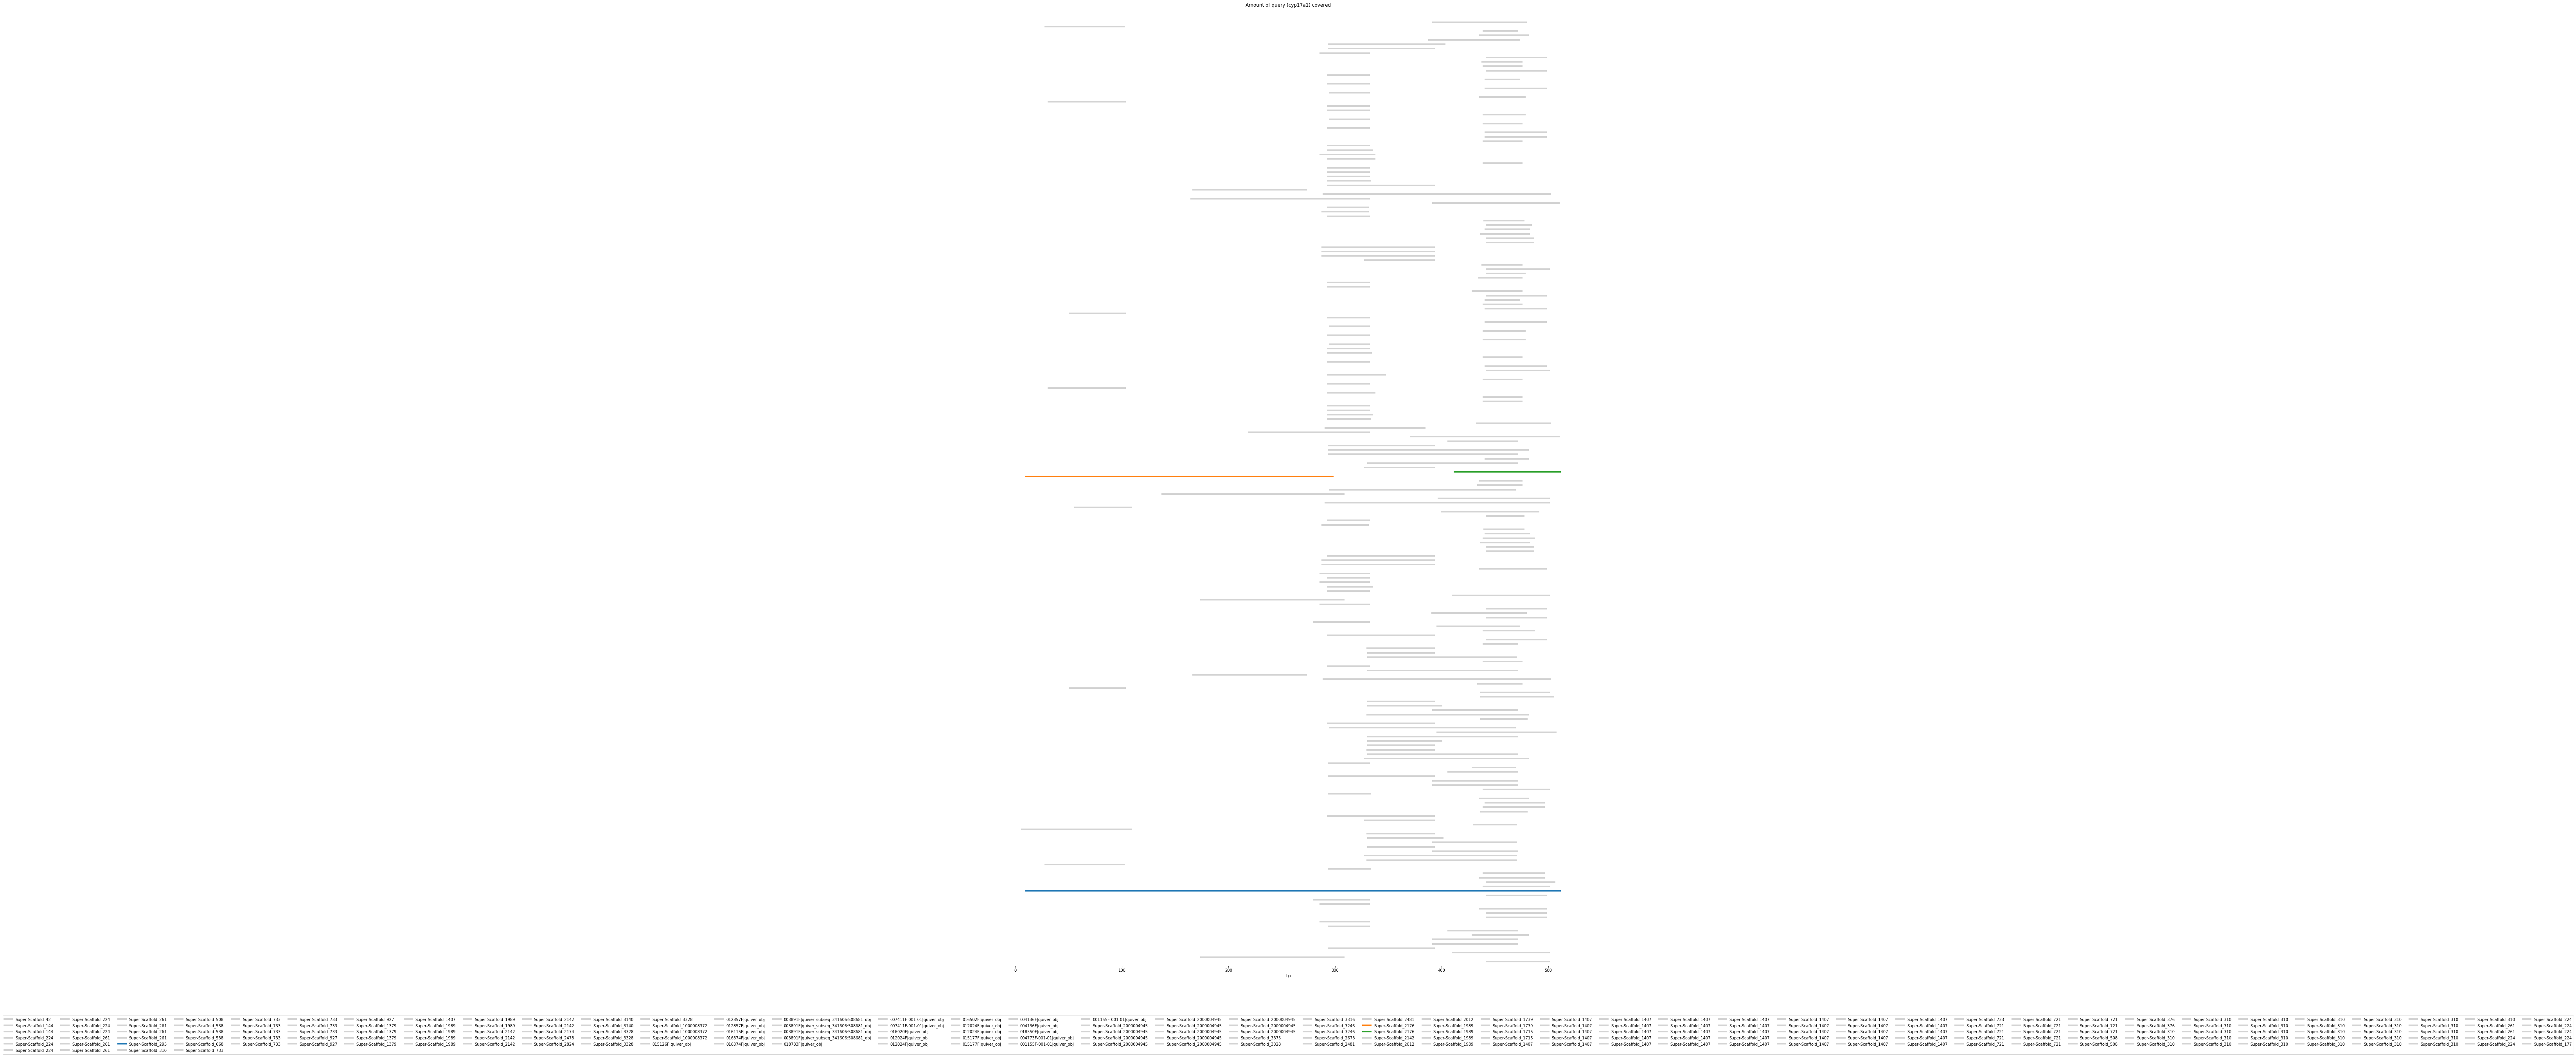

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_2176           Exon_3    512973    513257    284       
Super-Scaffold_2176           Exon_3    510973    515257    4284      (with flanking seq) 
Super-Scaffold_2176           Exon_2    506979    507117    138       
Super-Scaffold_2176           Exon_2    504979    509117    4138      (with flanking seq) 
Super-Scaffold_2176           Exon_1    502438    504041    1603      
Super-Scaffold_2176           Exon_1    500438    506041    5603      (with flanking seq) 
Super-Scaffold_2176           Exon_5    348858    348980    122       
Super-Scaffold_2176           Exon_5    346858    350980    4122      (with flanking seq) 
Super-Scaffold_2176           Exon_4    487047    487343    296       
Super-Scaffold_2176           Exon_4    485047    489343    4296      (with flanking seq) 
Super-Scaffold_295            Exon_3    886972    887110    138      

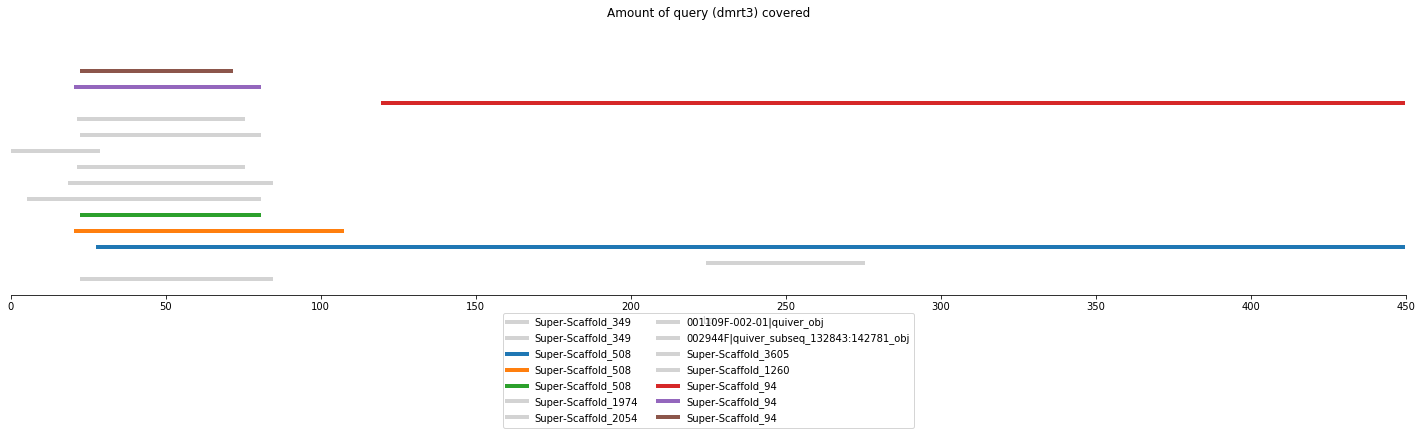

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_94             Exon_3    18236909  18236937  28        
Super-Scaffold_94             Exon_3    18234909  18238937  4028      (with flanking seq) 
Super-Scaffold_94             Exon_2    18160466  18161425  959       
Super-Scaffold_94             Exon_2    18158466  18163425  4959      (with flanking seq) 
Super-Scaffold_94             Exon_1    18014921  18015097  176       
Super-Scaffold_94             Exon_1    18012921  18017097  4176      (with flanking seq) 
Super-Scaffold_508            Exon_3    5634543   5634855   312       
Super-Scaffold_508            Exon_3    5632543   5636855   4312      (with flanking seq) 
Super-Scaffold_508            Exon_2    5643997   5644946   949       
Super-Scaffold_508            Exon_2    5641997   5646946   4949      (with flanking seq) 
Super-Scaffold_508            Exon_1    5791434   5791610   176      

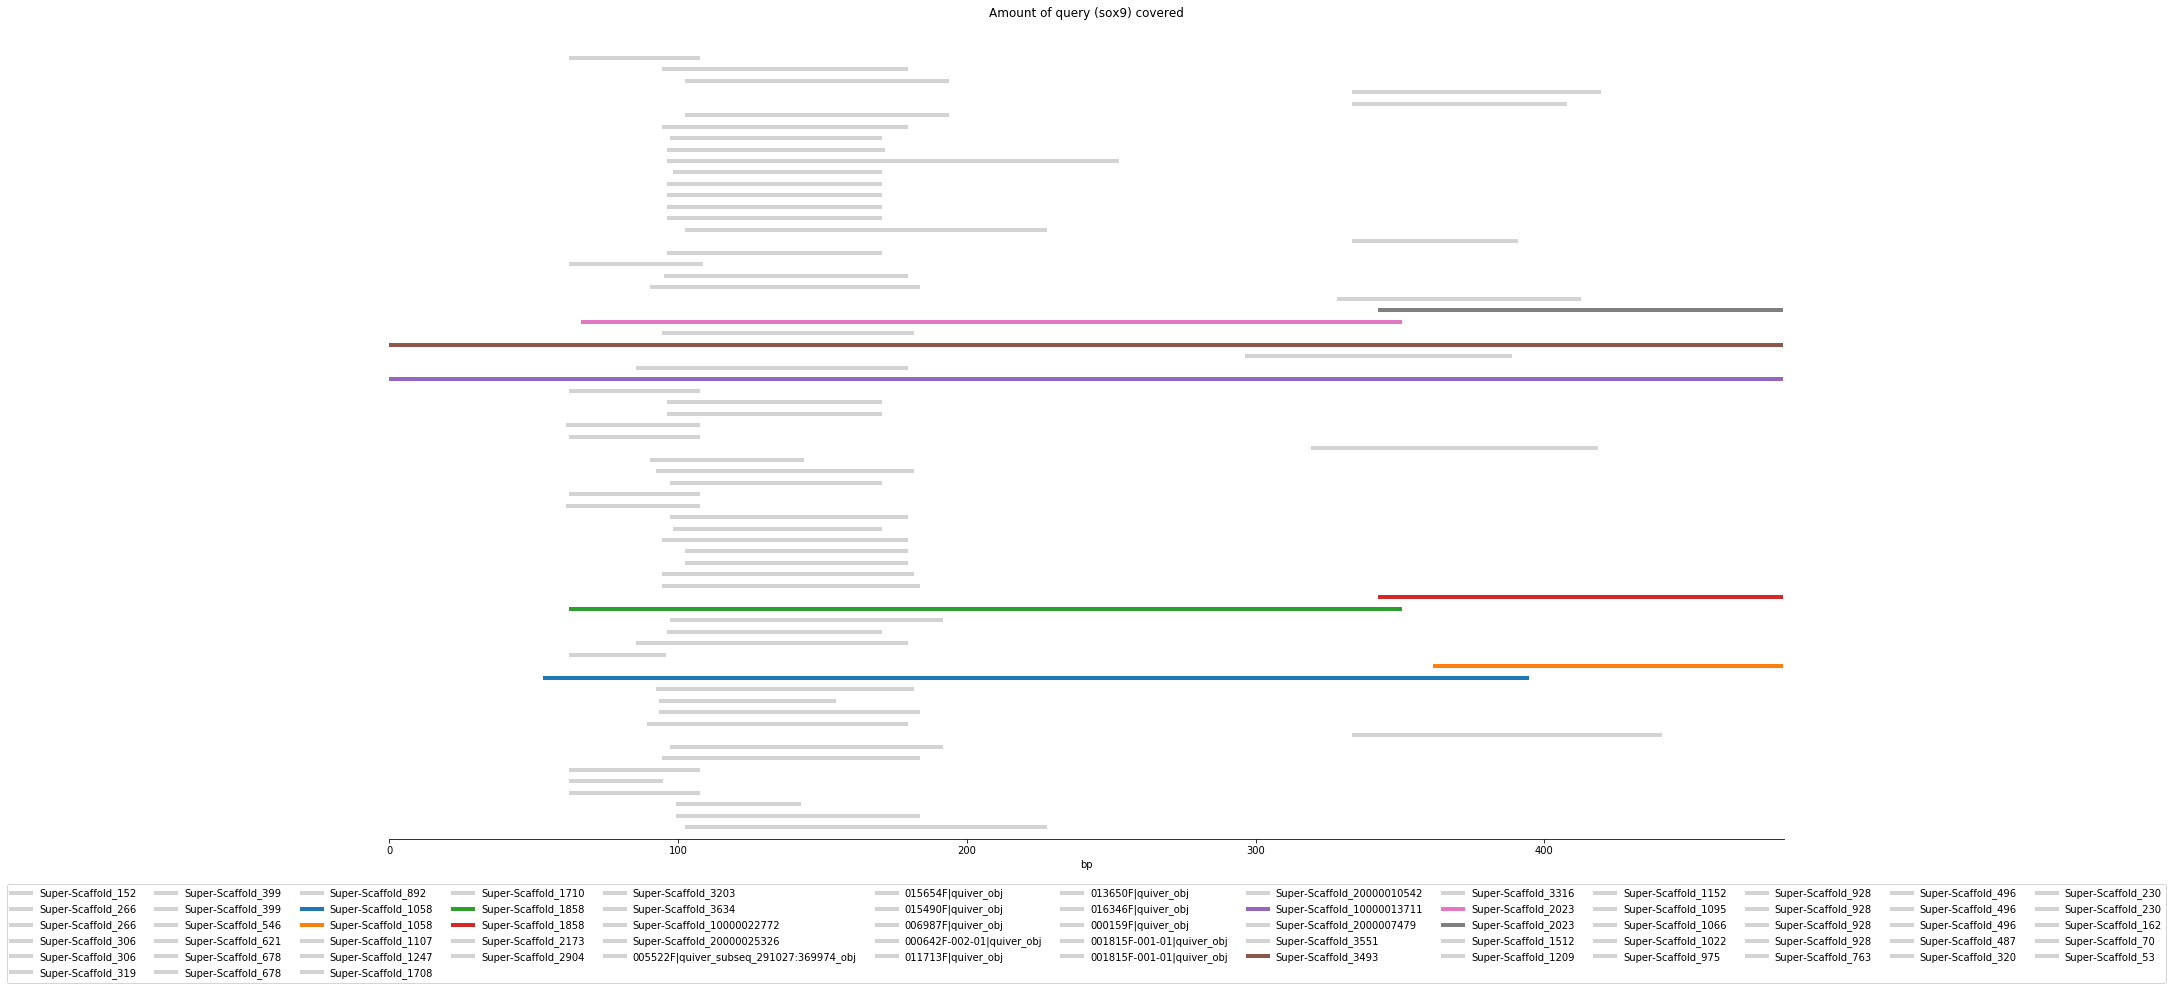

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_1058           Exon_3    3767439   3769675   2236      
Super-Scaffold_1058           Exon_3    3765439   3771675   6236      (with flanking seq) 
Super-Scaffold_1058           Exon_2    3768587   3769675   1088      
Super-Scaffold_1058           Exon_2    3766587   3771675   5088      (with flanking seq) 
Super-Scaffold_1058           Exon_1    3769002   3769675   673       
Super-Scaffold_1058           Exon_1    3767002   3771675   4673      (with flanking seq) 
Super-Scaffold_2023           Exon_3    302782    303011    229       
Super-Scaffold_2023           Exon_3    300782    305011    4229      (with flanking seq) 
Super-Scaffold_2023           Exon_2    288172    292713    4541      
Super-Scaffold_2023           Exon_2    286172    294713    8541      (with flanking seq) 
Super-Scaffold_2023           Exon_1    288172    288896    724      

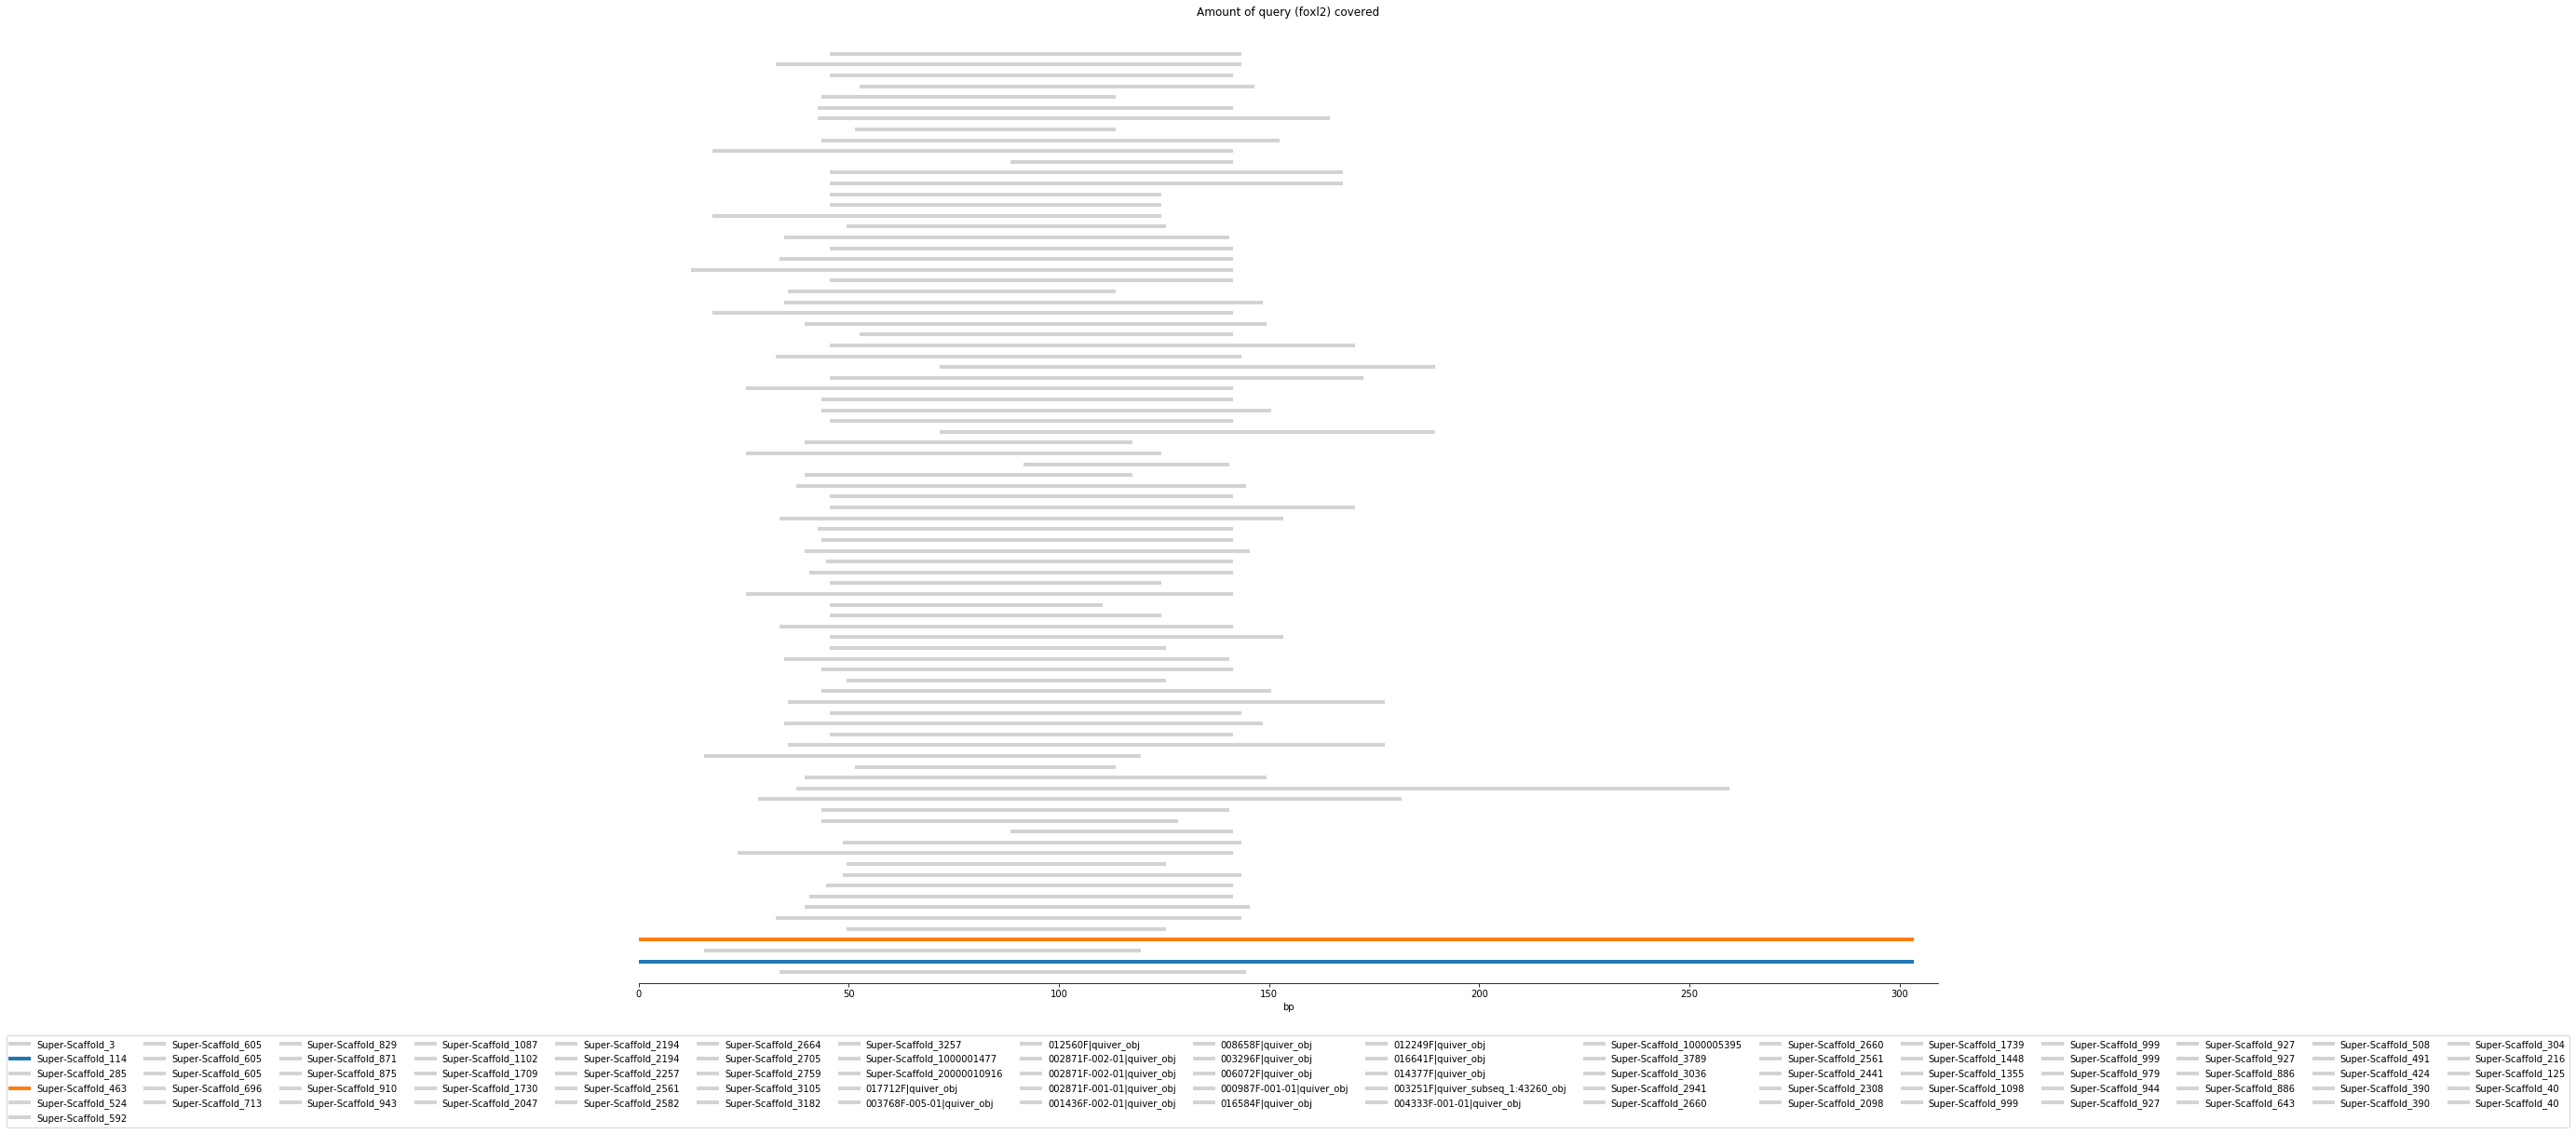

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_463            Exon_1    1509094   1510002   908       
Super-Scaffold_463            Exon_1    1507094   1512002   4908      (with flanking seq) 
Super-Scaffold_114            Exon_1    1372889   1373797   908       
Super-Scaffold_114            Exon_1    1370889   1375797   4908      (with flanking seq) 

Summary written to /home/djeffrie/Data/Sexome/Exoneroate_protein_outs//foxl2_prot_exonor_OUT_summary.txt

Getting segments from genome . . . 

Sequence length totalled 1816 Bp

Sequence length with flanking regions (2000) totalled 9816 Bp

DONE! Sequence segments are here /home/djeffrie/Data/Sexome/Exoneroate_protein_outs//foxl2_prot_exonor_OUT_segments.fa

sox3

overlapping (scaff Super-Scaffold_70): Exon_3 , Exon_2, STRT_1: 306507, STOP_1: 310757, STRT_2: 306178, STOP_2: 310332
overlapping (scaff Super-Scaffold_70): Exon_3 , Exon_1, STRT_1: 30650

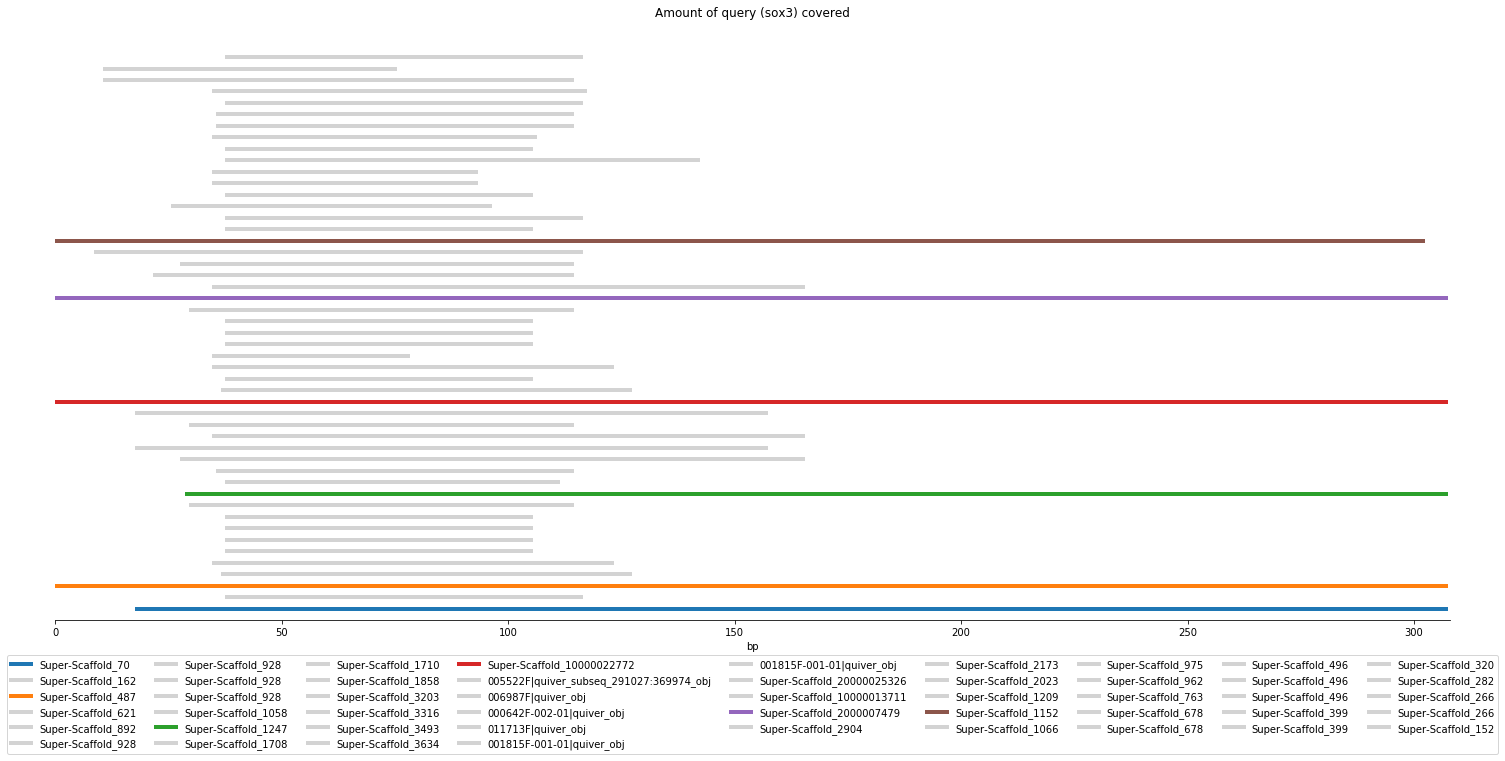

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_70             Exon_3    307740    308896    1156      
Super-Scaffold_70             Exon_3    305740    310896    5156      (with flanking seq) 
Super-Scaffold_70             Exon_2    308178    308896    718       
Super-Scaffold_70             Exon_2    306178    310896    4718      (with flanking seq) 
Super-Scaffold_70             Exon_1    308507    308896    389       
Super-Scaffold_70             Exon_1    306507    310896    4389      (with flanking seq) 
Super-Scaffold_487            Exon_1    2118700   2119617   917       
Super-Scaffold_487            Exon_1    2116700   2121617   4917      (with flanking seq) 
Super-Scaffold_1247           Exon_1    3276291   3277259   968       
Super-Scaffold_1247           Exon_1    3274291   3279259   4968      (with flanking seq) 
Super-Scaffold_10000022772    Exon_1    305394    306311    917      

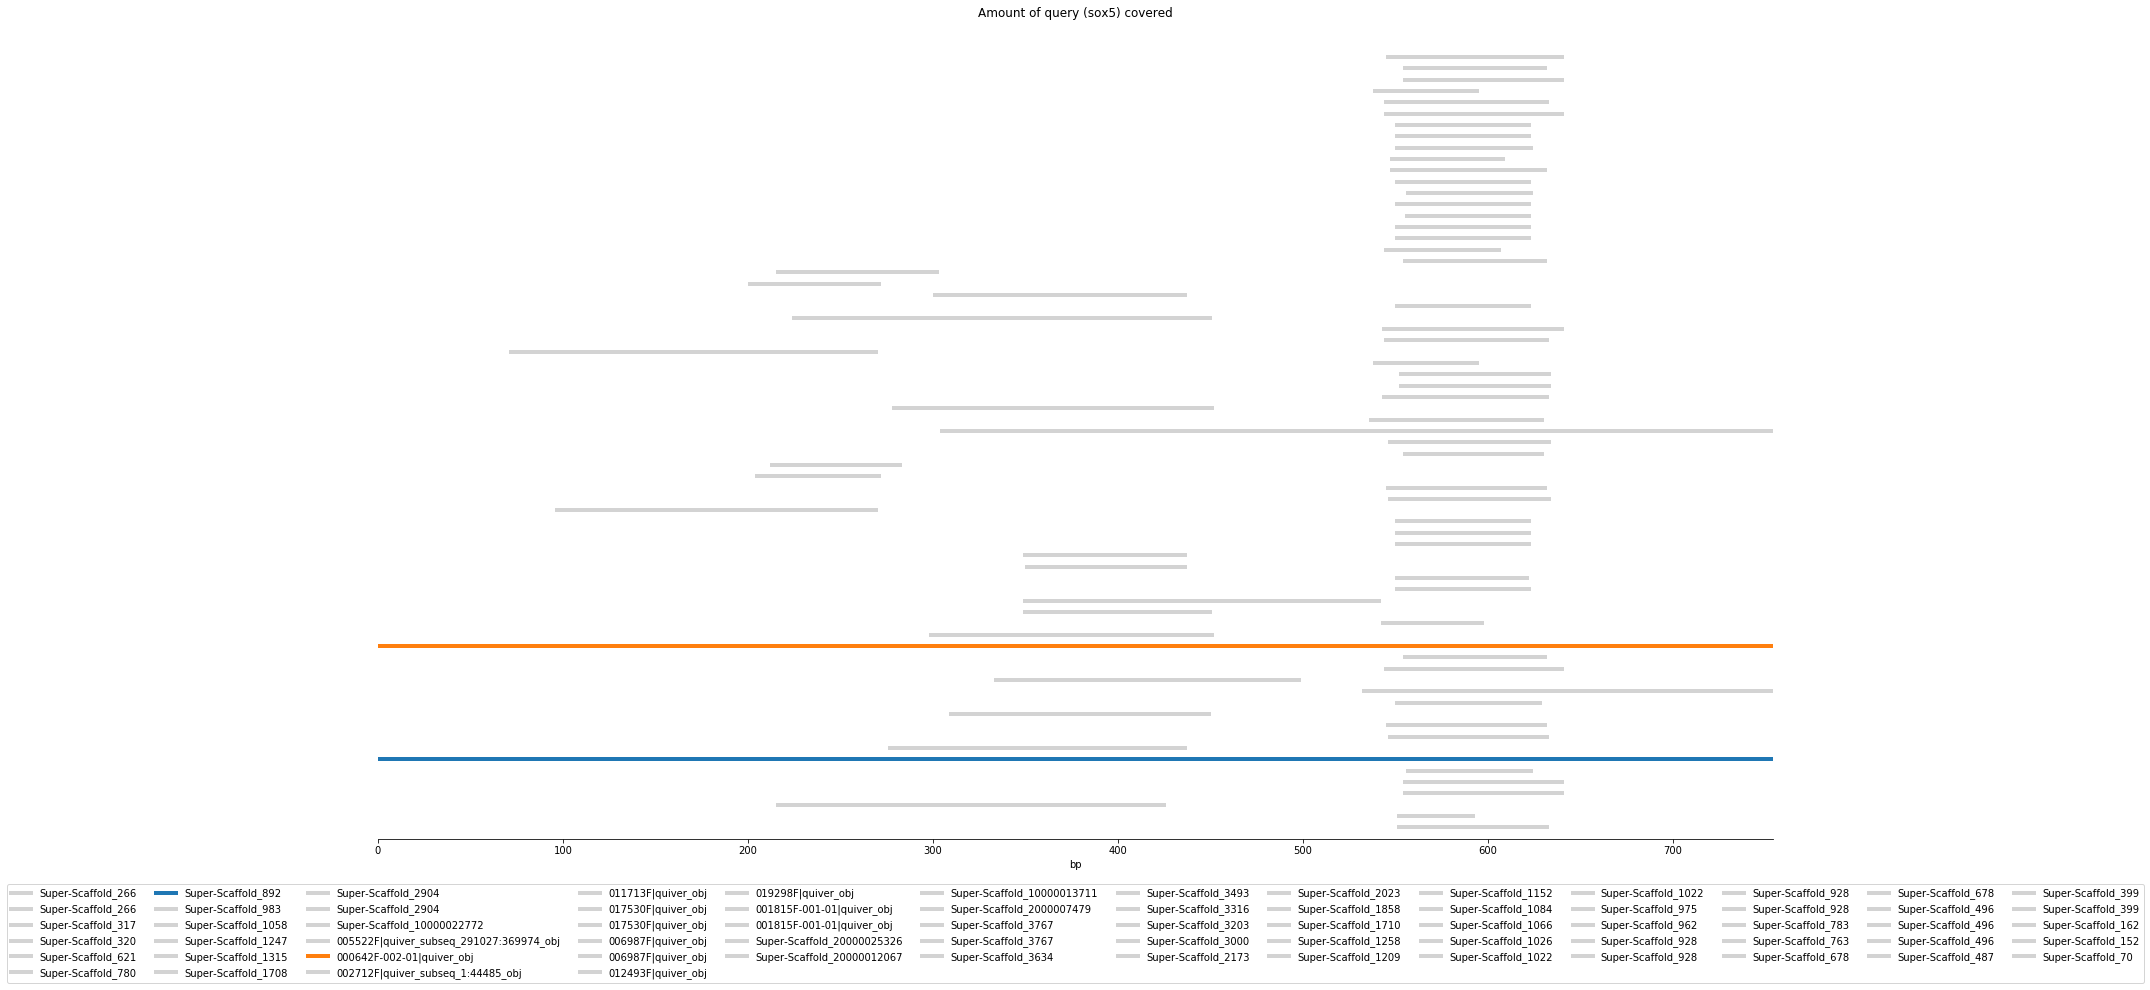

==================== Hits ======================

SCAFFOLD                      EXON      START     STOP      LENGTH    
Super-Scaffold_892            Exon_13   2454218   2454286   68        
Super-Scaffold_892            Exon_13   2452218   2456286   4068      (with flanking seq) 
Super-Scaffold_892            Exon_12   2492781   2492907   126       
Super-Scaffold_892            Exon_12   2490781   2494907   4126      (with flanking seq) 
Super-Scaffold_892            Exon_11   2298442   2298479   37        
Super-Scaffold_892            Exon_11   2296442   2300479   4037      (with flanking seq) 
Super-Scaffold_892            Exon_10   2334866   2335097   231       
Super-Scaffold_892            Exon_10   2332866   2337097   4231      (with flanking seq) 
Super-Scaffold_892            Exon_14   2453088   2453260   172       
Super-Scaffold_892            Exon_14   2451088   2455260   4172      (with flanking seq) 
Super-Scaffold_892            Exon_9    2355803   2356013   210      

In [28]:
gff_dir = "/home/djeffrie/Data/Sexome/Exoneroate_protein_outs/"
my_genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
flanking_bp = 2000

hit_dict_dict = {}
curated_hit_dict = {}

Retained_target_seq_total = 0

for gene in exonorate_OUTS_dict:
    
    print "\n%s\n" % gene
    
    hit_dict_dict[gene], curated_hit_dict[gene], Seq_total  = exonerator_exons("%s/%s" % (gff_dir, exonorate_OUTS_dict[gene]["File"]), 
                                                                               my_genome_path, 
                                                                               gene, 
                                                                               exonorate_OUTS_dict[gene]["Query_length"],
                                                                               flanking_bp,
                                                                               exonorate_OUTS_dict[gene]["target_scaffs"])
    Retained_target_seq_total += Seq_total
    
    
    

## Summary so far

So my script I think works well (i.e. it does what its supposed to). All that remains is for me to settle on what flanking window size to use. 

**When I use a window size of 2kb, the total amount of target sequence is 540 Kb. Whereas if I use a 1 Kb flanking size, the total amount of sequence retained goes down to just 283 Kb.**

With the transcriptome genes, I can target another ~519 kb with 100 genes across 3 chromosomes. So with 283 kb that would be almost exactly 800Kb. However, I think a lot of the intron sequence in the flanking regions will be repetitive. After masking or removing redundant probes, I think that the 2kb flanking window could be the better choice. 
